# Imports

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output

from sklearn.preprocessing import StandardScaler

import torch
from torch.nn import Parameter
from torch_geometric.nn import HeteroConv, SAGEConv, GCNConv, GATConv
from torch_geometric.nn.inits import glorot
import torch.nn as nn
from torch.optim import Adam
from torch.nn import MSELoss
from torch_geometric_temporal.signal import DynamicHeteroGraphTemporalSignal

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed()

# Tabular to graph

In [4]:
data = pd.read_csv("waterflood-master/data/train/train_data.csv")

d = {
    "НЕФ": "P",
    "НАГ": "I",
}
data["CHARWORK"] = data["CHARWORK"].map(d)
data["MEASURED_IN_DATE"] = pd.to_datetime(data["MEASURED_IN_DATE"])
data = data.drop(["MEASURED_IN", "KCHARWORK"], axis=1)

print(data.shape)
display(data.head())

(177575, 9)


,MEASURED_IN_DATE,WELL_NAME,CHARWORK,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,WELLHEAD_PRESSURE,IS_WORKING
0,2017-02-01,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
1,2017-02-02,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
2,2017-02-03,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
3,2017-02-04,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
4,2017-02-05,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True


In [5]:
data.describe()

,MEASURED_IN_DATE,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,WELLHEAD_PRESSURE
count,177575,177575.000000,177575.000000,166194.000000,177575.000000,50393.000000
mean,2020-11-08 21:58:36.271997440,232.797567,25.001408,80.846916,160.055048,124.874784
min,2016-08-02 00:00:00,0.000000,0.000000,4.380000,0.000000,10.000000
25%,2020-03-17 00:00:00,0.000000,0.000000,52.522500,0.000000,115.000000
50%,2021-03-17 00:00:00,129.000000,9.000000,66.510000,0.000000,138.000000
75%,2021-10-24 00:00:00,348.000000,46.000000,95.390000,183.000000,148.000000
max,2022-05-31 00:00:00,1622.000000,99.900000,276.940000,1775.000000,180.000000
std,NaN,289.178515,30.567793,43.104905,305.891882,35.849217


In [6]:
print(f'Number of wells: {len(data["WELL_NAME"].unique())}')

Number of wells: 266


In [7]:
print("Number of wells of each group:")
tmp = data.drop_duplicates(subset=["WELL_NAME", "CHARWORK"])
tmp.groupby("CHARWORK").agg({"WELL_NAME": "count"})

Number of wells of each group:


,WELL_NAME
CHARWORK,
I,61
P,257


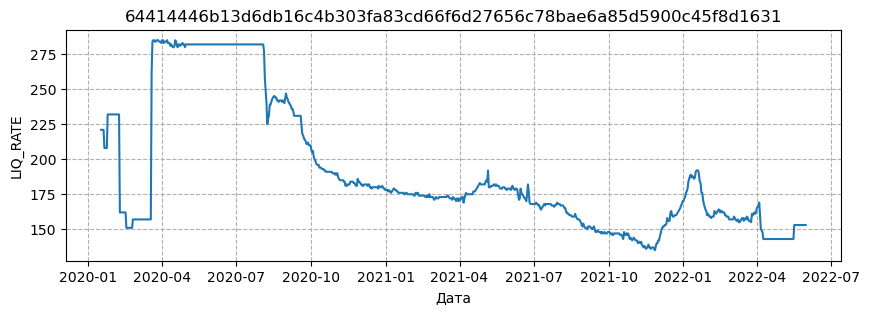

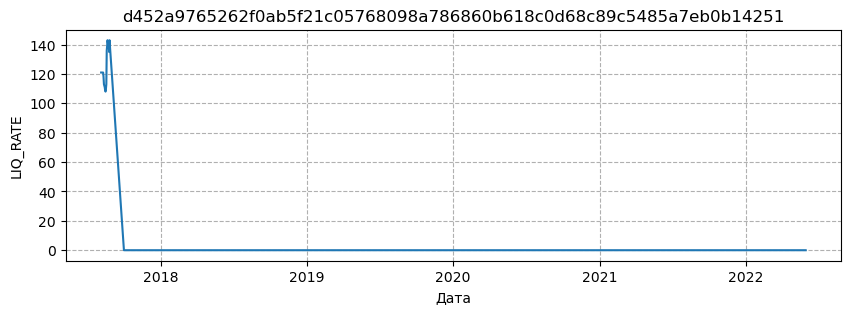

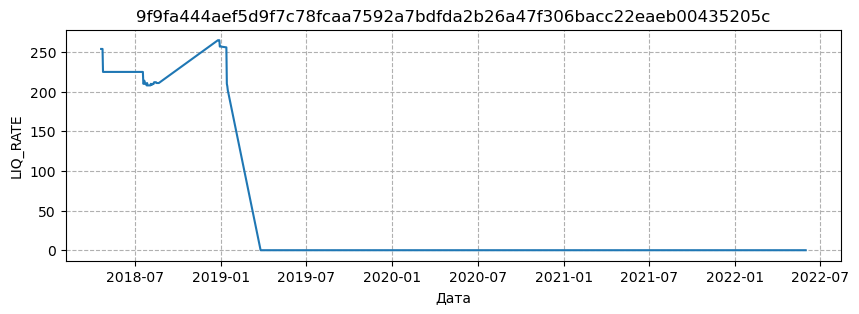

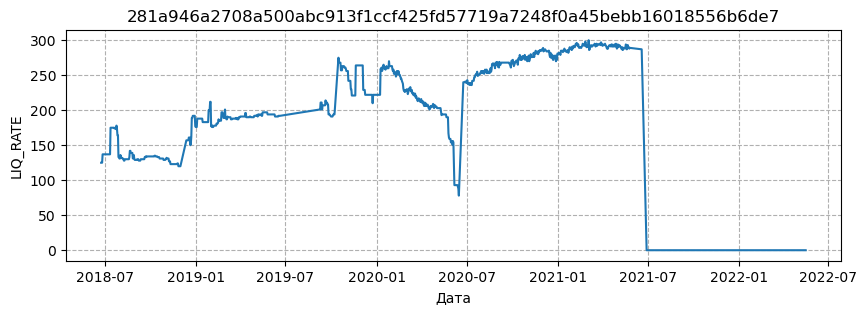

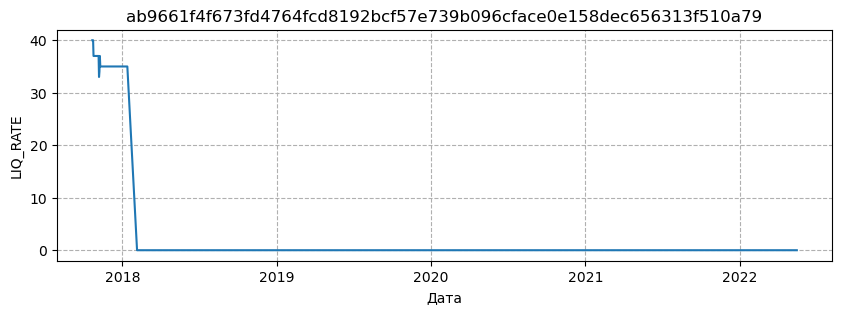

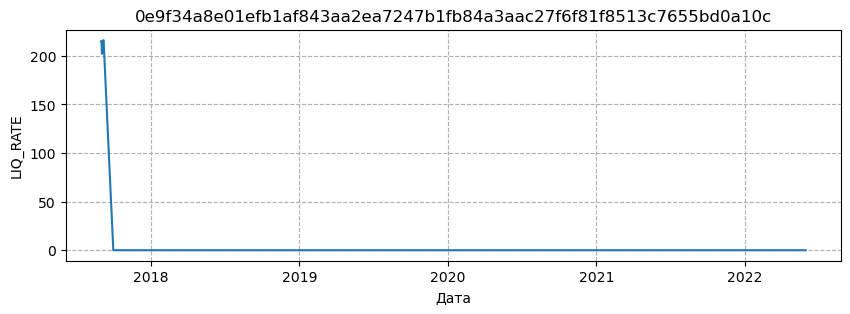

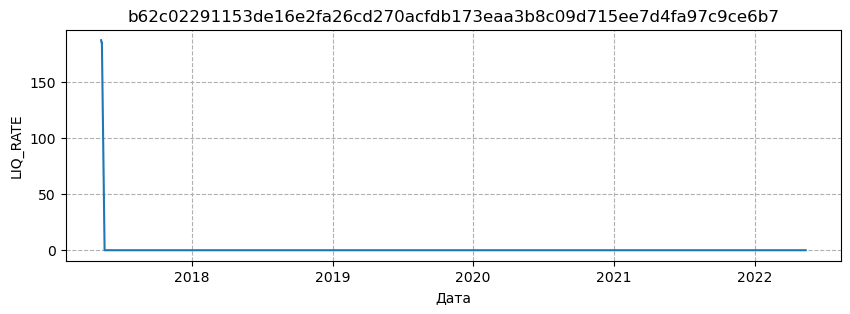

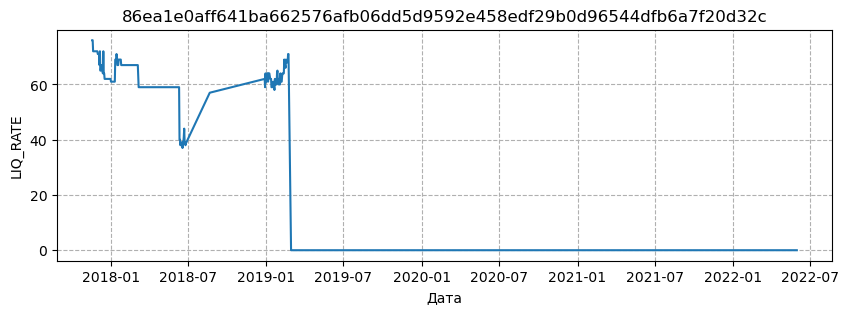

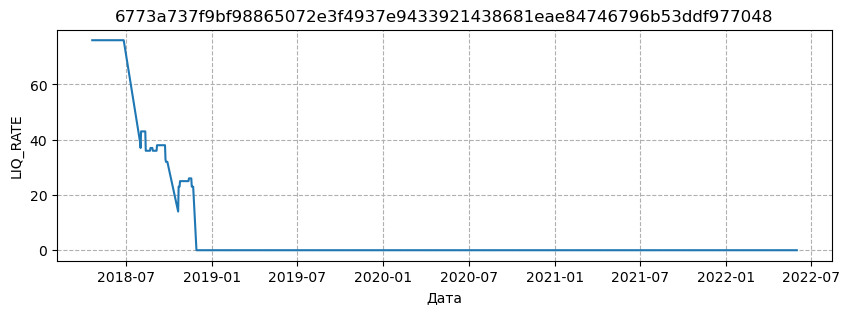

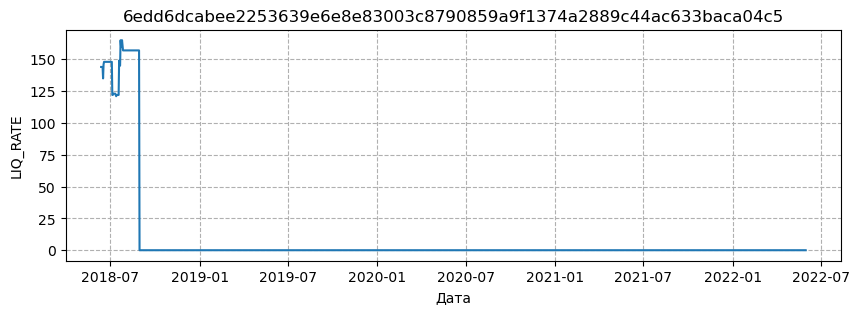

In [8]:
param = "LIQ_RATE"

for well in data[(data["CHARWORK"] == "P")]["WELL_NAME"].unique()[:10]:
    tmp = data[data["WELL_NAME"] == well]
    plt.figure(figsize=(10, 3))

    plt.plot(tmp["MEASURED_IN_DATE"], tmp[param])
    plt.grid(ls="--")
    plt.title(well)
    plt.xlabel("Дата")
    plt.ylabel(param)

In [9]:
grouped_df = data.groupby(["WELL_NAME"], as_index=True).agg({"CHARWORK": ["unique"]})
grouped_df.columns = ["_".join(x).rstrip("_") for x in grouped_df.columns.ravel()]
grouped_df["CHARWORK_unique"] = [
    ",".join(map(str, l)) for l in grouped_df["CHARWORK_unique"]
]
only_one_role = grouped_df[grouped_df["CHARWORK_unique"].astype("str").str.len() == 1]
one_role_list = only_one_role.index.tolist()
only_one_role.CHARWORK_unique.value_counts()

CHARWORK_unique
P    205
I      9
Name: count, dtype: int64

In [11]:
data_filtered = data[data["WELL_NAME"].isin(one_role_list)]
data_filtered

,MEASURED_IN_DATE,WELL_NAME,CHARWORK,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,WELLHEAD_PRESSURE,IS_WORKING
0,2017-02-01,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
1,2017-02-02,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
2,2017-02-03,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
3,2017-02-04,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
4,2017-02-05,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
...,...,...,...,...,...,...,...,...,...
177570,2022-05-27,1de41569155b66df7355c8fc7a53e80333aea79dc9bb37...,P,328.0,70.0,60.73,0.0,NaN,True
177571,2022-05-28,1de41569155b66df7355c8fc7a53e80333aea79dc9bb37...,P,328.0,70.0,60.73,0.0,NaN,True
177572,2022-05-29,1de41569155b66df7355c8fc7a53e80333aea79dc9bb37...,P,328.0,70.0,60.73,0.0,NaN,True
177573,2022-05-30,1de41569155b66df7355c8fc7a53e80333aea79dc9bb37...,P,328.0,70.0,60.73,0.0,NaN,True


In [13]:
# load coordinates
def get_coords():
    """Load coordinates from csv file."""
    df = pd.read_csv("waterflood-master/data/train/coords.csv")
    print(df.shape)
    print(df["WELL_NAME"].nunique())

    return df


coords = get_coords()

# оставить только те скважины что есть в трейне
coords = coords[coords["WELL_NAME"].isin(data_filtered["WELL_NAME"].unique())]
print(coords.shape)
print(coords["WELL_NAME"].nunique())

coords = pd.merge(coords, grouped_df, on="WELL_NAME", how="left")


coords.head()

(424, 5)
424
(214, 5)
214


,WELL_NAME,COORD_X,COORD_Y,X2,Y2,CHARWORK_unique
0,769384f0a6fe5cba75fc68a9e52395eb9b69fa8dab849e...,11611.72,3450.28,11769.95,2921.20,P
1,59e8ab92b257d0809933a49847143f08b2143d238856e8...,14147.72,4947.28,13926.47,5554.19,P
2,6ab87d3e097b485c5bdd13b3940ec9c160fe5e77163d2e...,13982.72,6816.28,13947.17,6771.63,I
3,e420bc59a8c8c472f1307d05a6890c5e0626355f4002e1...,14908.72,7200.28,14892.66,7125.06,I
4,e19331bdf30e35b29c747db0c828bf630b4e99043f5e5d...,12873.72,4516.28,13032.47,3964.13,P


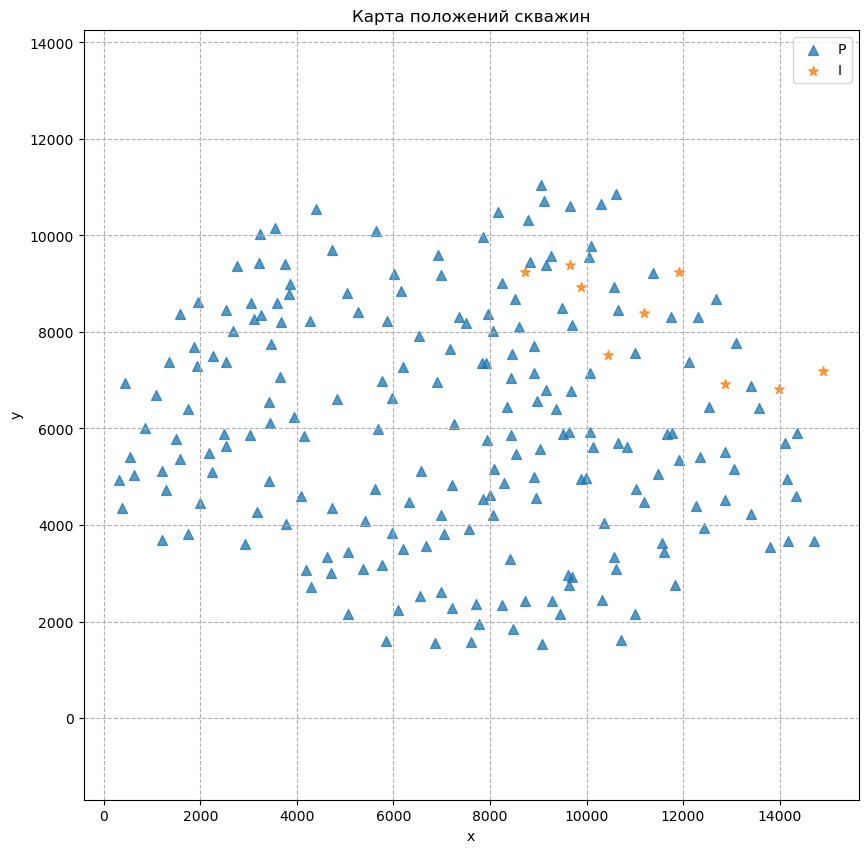

In [16]:
plt.figure(figsize=(10, 10))

for well_type in coords["CHARWORK_unique"].unique():
    tmp = coords[coords["CHARWORK_unique"] == well_type].copy()
    if well_type == "I":  # Нагнетательная скважина
        marker = "*"  # Звездочка
    else:  # Добывающая скважина
        marker = "^"  # Треугольник
    plt.scatter(
        tmp["COORD_X"],
        tmp["COORD_Y"],
        # label="Вход в пласт",
        label=well_type,
        s=50,
        alpha=0.75,
        marker=marker
    )
# plt.scatter(coords["X2"], coords["Y2"], label="Выход из пласта", s=5, alpha=0.75)


plt.title("Карта положений скважин")
plt.axis("equal")
plt.grid(ls="--")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("plots/RN_coords.png", bbox_inches='tight')
plt.show()

In [14]:
p_wells = data_filtered[data_filtered.loc[:, "CHARWORK"] == 'P'].sort_values("MEASURED_IN_DATE")["WELL_NAME"].unique()
i_wells = data_filtered[data_filtered.loc[:, "CHARWORK"] == 'I'].sort_values("MEASURED_IN_DATE")["WELL_NAME"].unique()

p_coords = coords[coords["WELL_NAME"].isin(p_wells)]
i_coords = coords[coords["WELL_NAME"].isin(i_wells)]

In [15]:
new_p_ids = list(range(len(p_wells)))
new_i_ids = list(range(len(i_wells)))

p_mapping = dict(zip(p_wells, new_p_ids))
i_mapping = dict(zip(i_wells, new_i_ids))
p_mapping_inv = dict(zip(new_p_ids, p_wells))
i_mapping_inv = dict(zip(new_i_ids, i_wells))
mapping = {**p_mapping, **i_mapping}

data_filtered.loc[:, "WELL_NAME"] = data_filtered["WELL_NAME"].map(mapping)

p_coords.loc[:, "WELL_NAME"] = p_coords["WELL_NAME"].map(p_mapping)
i_coords.loc[:, "WELL_NAME"] = i_coords["WELL_NAME"].map(i_mapping)

# print(p_mapping, i_mapping)
# print(p_mapping_inv, i_mapping_inv)

In [27]:
data_filtered[(data_filtered["CHARWORK"] == "I") & (data_filtered["LIQ_RATE"] != 0)]

,MEASURED_IN_DATE,WELL_NAME,CHARWORK,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,WELLHEAD_PRESSURE,IS_WORKING


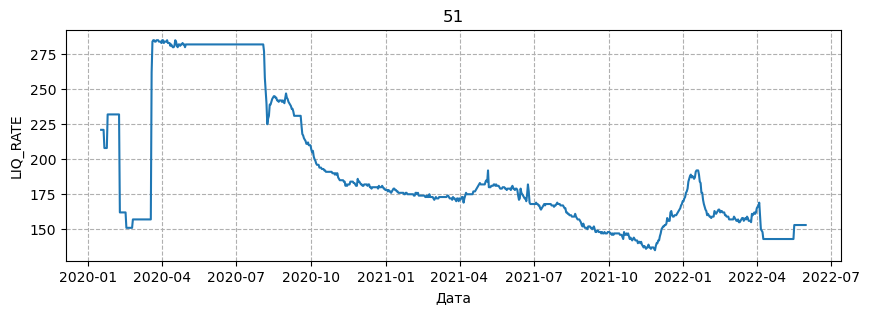

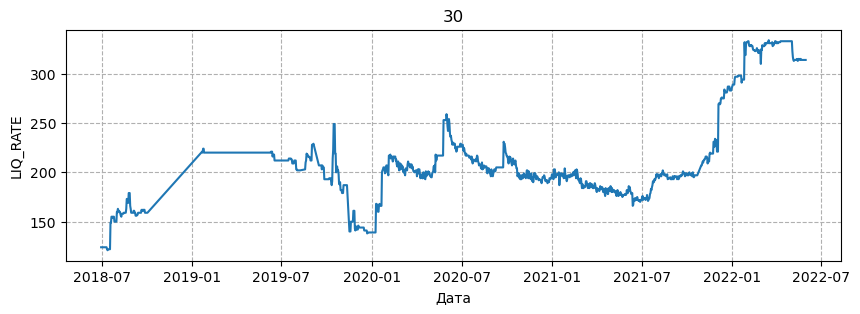

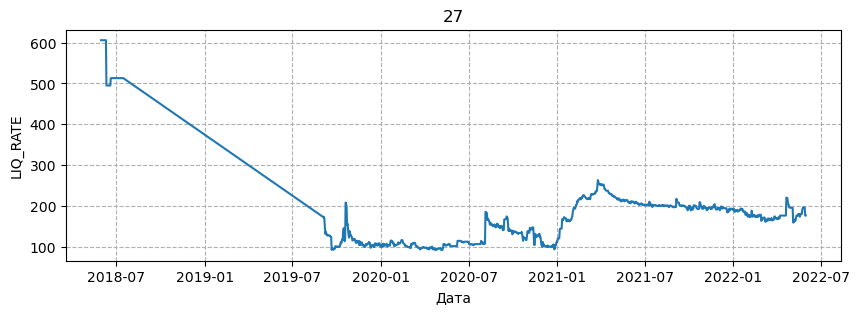

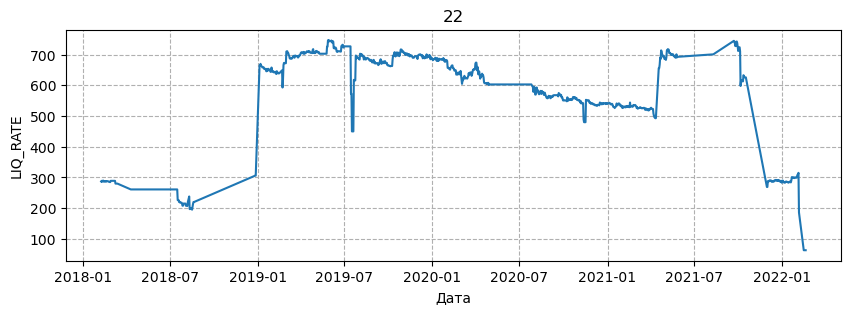

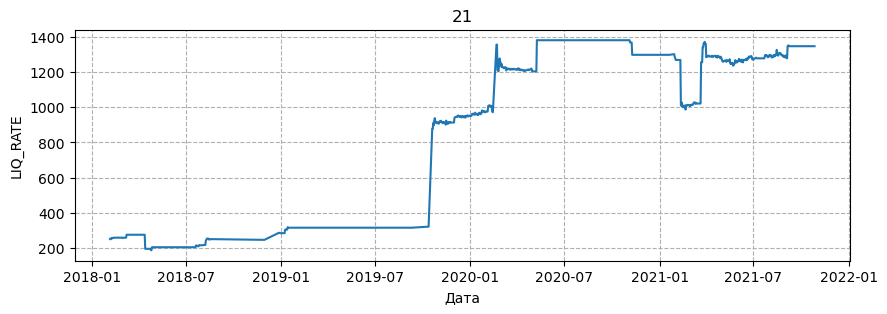

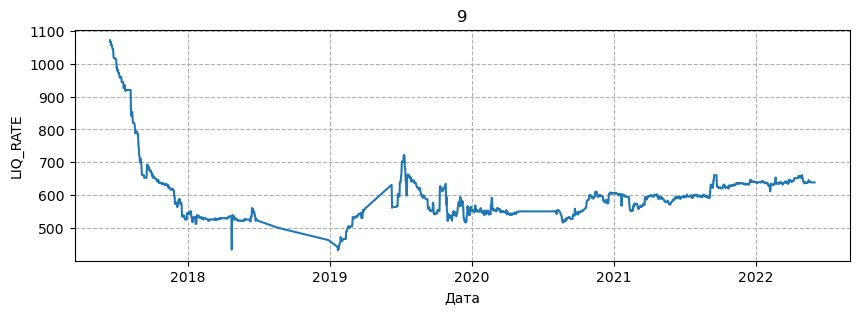

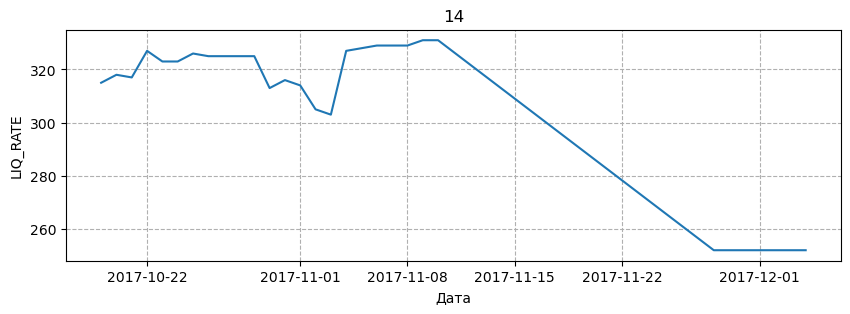

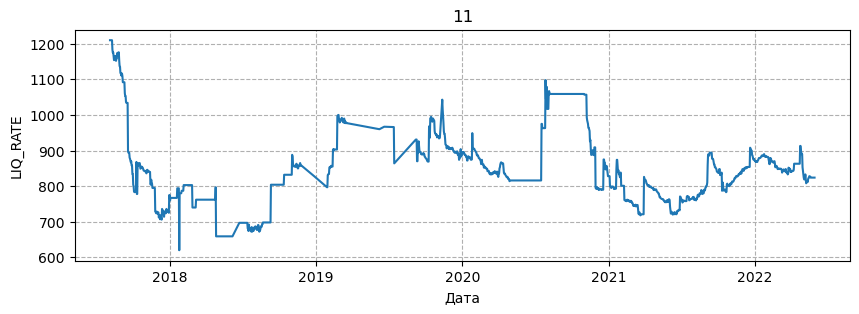

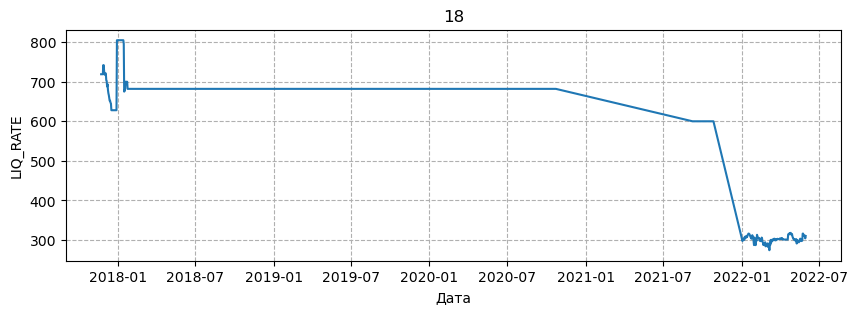

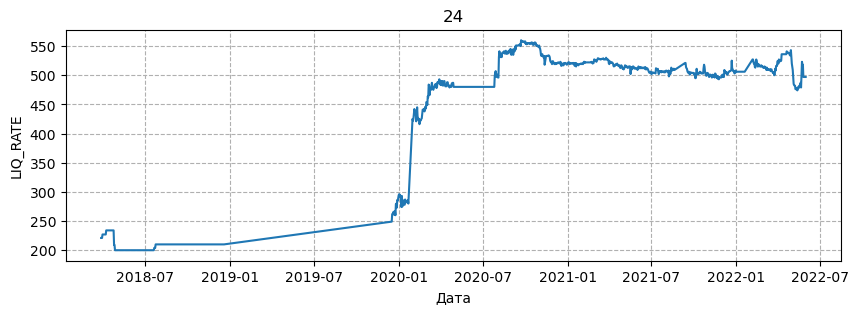

In [18]:
param = "LIQ_RATE"

for well in data_filtered[(data_filtered["CHARWORK"] == "P")]["WELL_NAME"].unique()[:10]:
    tmp = data_filtered[data_filtered["WELL_NAME"] == well]
    plt.figure(figsize=(10, 3))

    plt.plot(tmp["MEASURED_IN_DATE"], tmp[param])
    plt.grid(ls="--")
    plt.title(well)
    plt.xlabel("Дата")
    plt.ylabel(param)

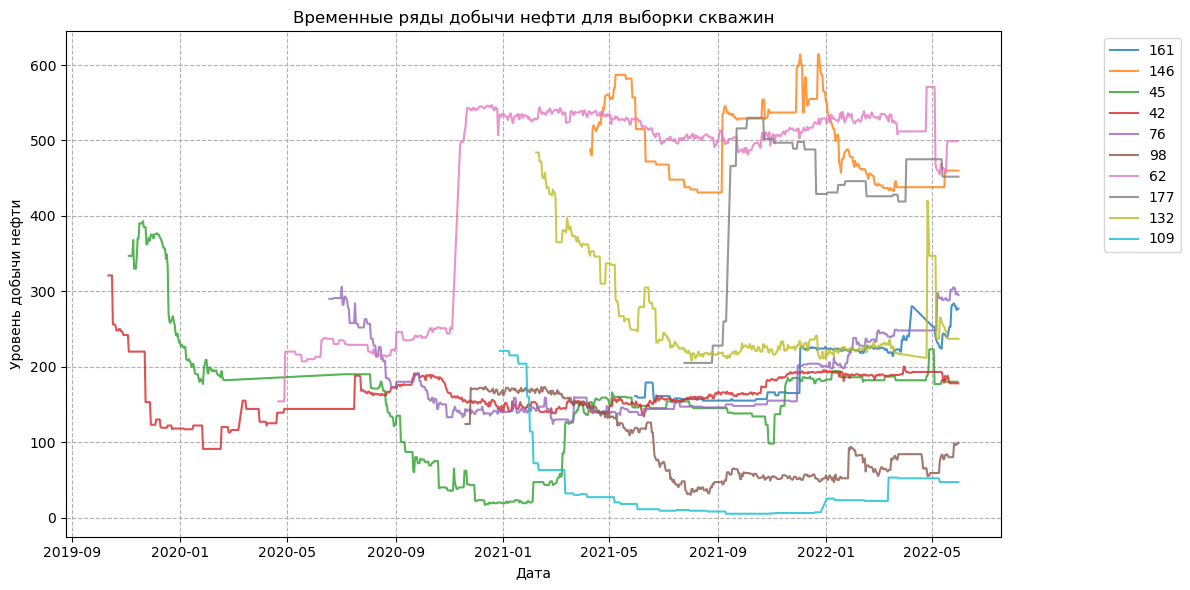

In [21]:
wells = random.sample(list(data_filtered[(data_filtered["CHARWORK"] == "P")]["WELL_NAME"].unique()), 10)

# Создаем фигуру
plt.figure(figsize=(12, 6))

# Цветовая палитра для скважин
colors = plt.cm.tab10.colors  # Используем встроенную цветовую палитру с 10 цветами

# Строим графики для каждой скважины
for i, well in enumerate(wells):
    tmp = data_filtered[data_filtered["WELL_NAME"] == well]
    plt.plot(
        tmp["MEASURED_IN_DATE"], 
        tmp["LIQ_RATE"], 
        label=well, 
        color=colors[i % len(colors)],  # Циклически выбираем цвет
        alpha=0.8  # Прозрачность линий
    )

# Добавляем сетку, заголовок и подписи осей
plt.grid(ls="--")
plt.title("Временные ряды добычи нефти для выборки скважин")
plt.xlabel("Дата")
plt.ylabel("Уровень добычи нефти")

# Добавляем легенду
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=10)

# Настройка макета для предотвращения перекрытия элементов
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig("plots/oil_RN_combined.png", bbox_inches='tight')
plt.show()

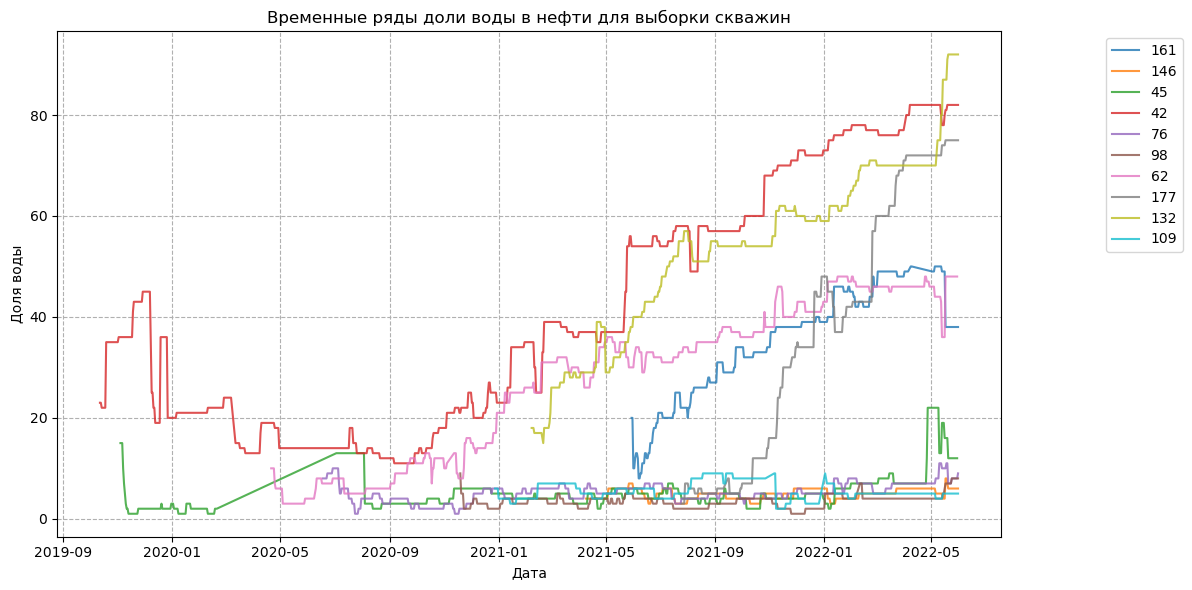

In [22]:
# Создаем фигуру
plt.figure(figsize=(12, 6))

# Цветовая палитра для скважин
colors = plt.cm.tab10.colors  # Используем встроенную цветовую палитру с 10 цветами

# Строим графики для каждой скважины
for i, well in enumerate(wells):
    tmp = data_filtered[data_filtered["WELL_NAME"] == well]
    plt.plot(
        tmp["MEASURED_IN_DATE"], 
        tmp["WATER_CUT"], 
        label=well, 
        color=colors[i % len(colors)],  # Циклически выбираем цвет
        alpha=0.8  # Прозрачность линий
    )

# Добавляем сетку, заголовок и подписи осей
plt.grid(ls="--")
plt.title("Временные ряды доли воды в нефти для выборки скважин")
plt.xlabel("Дата")
plt.ylabel("Доля воды")

# Добавляем легенду
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=10)

# Настройка макета для предотвращения перекрытия элементов
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig("plots/watercut_RN_combined.png", bbox_inches='tight')
plt.show()

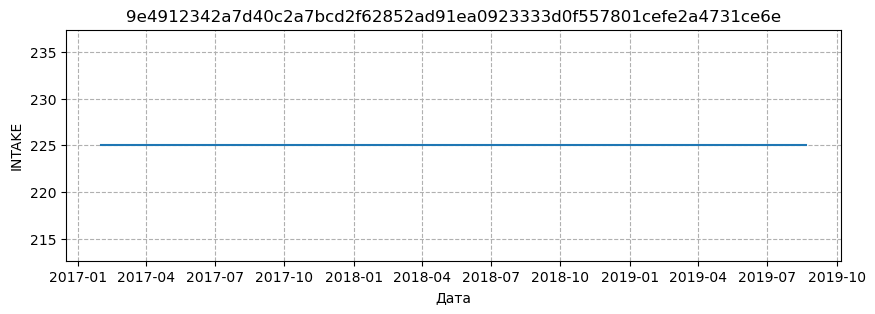

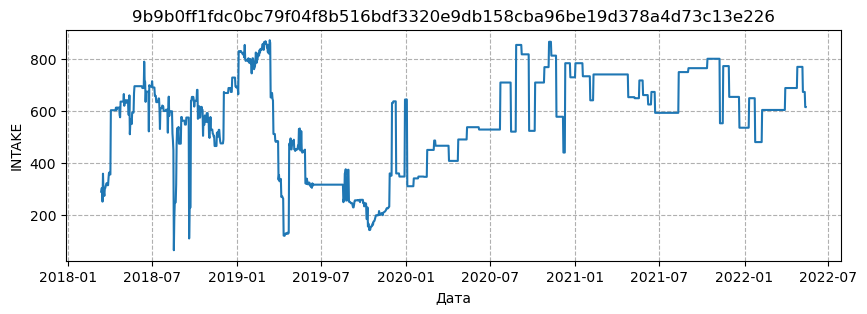

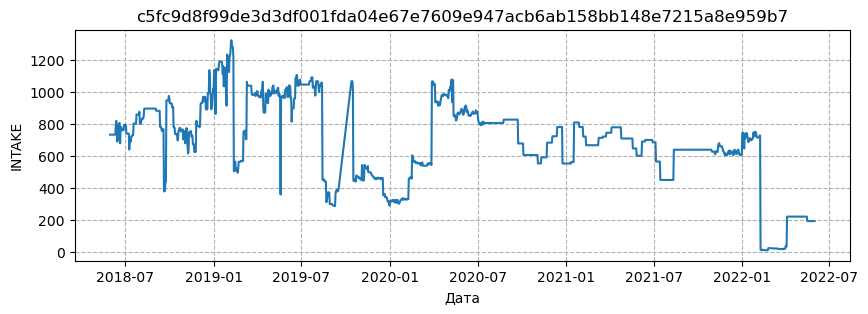

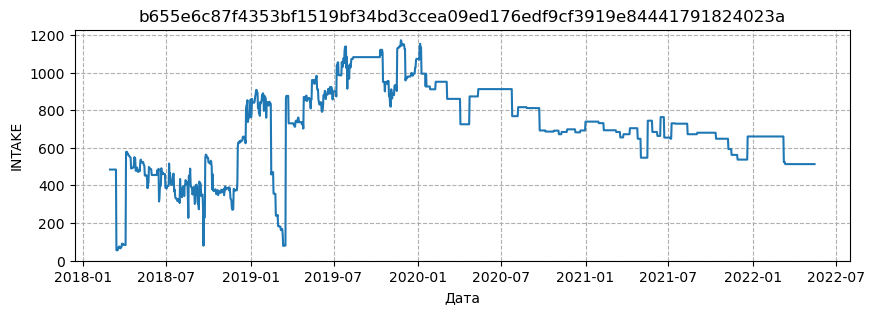

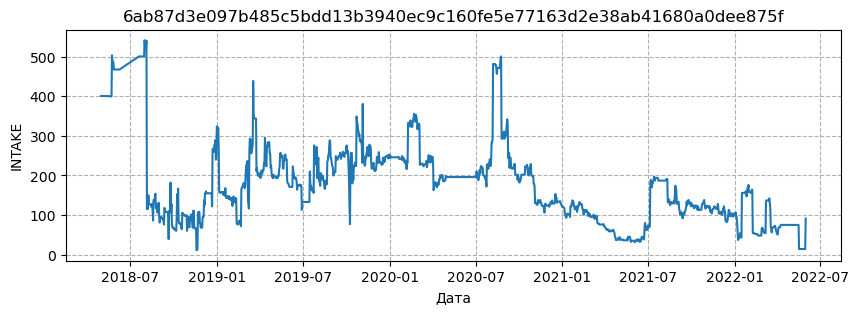

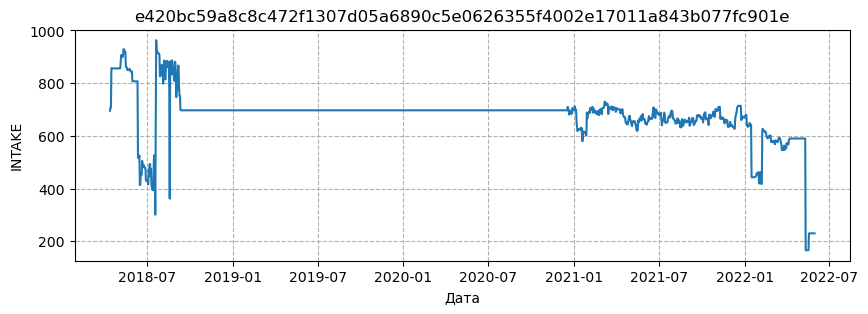

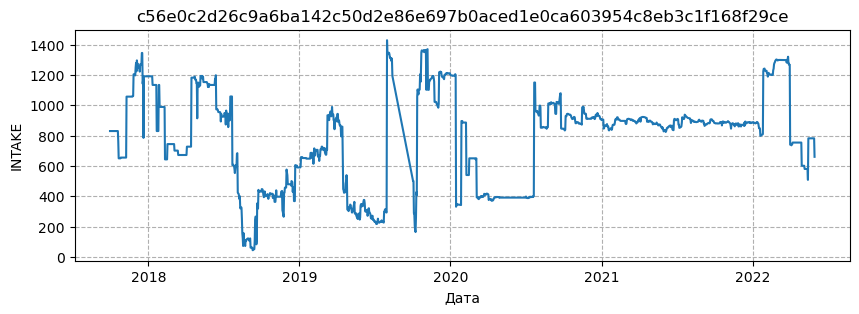

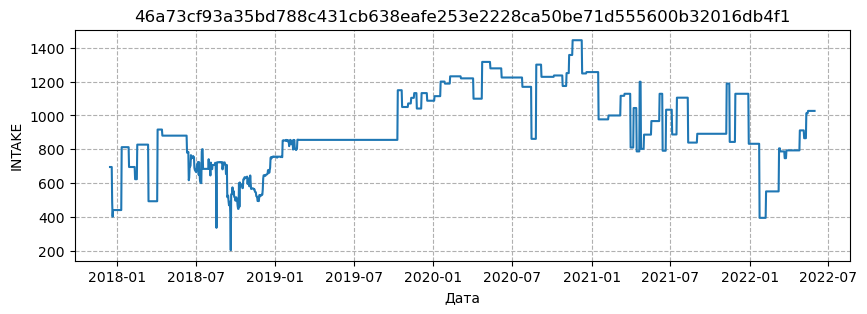

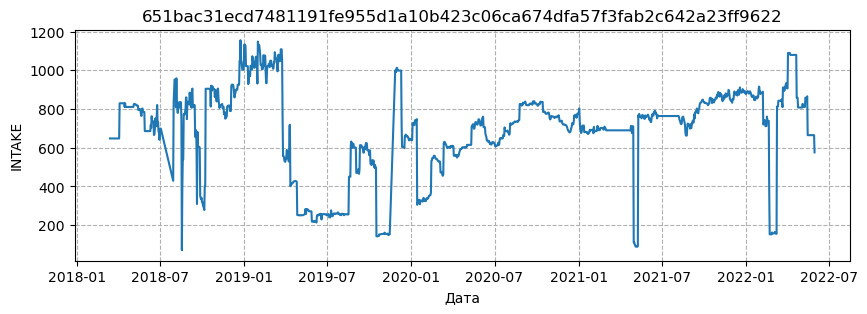

In [12]:
param = "INTAKE"

for well in data_filtered[(data_filtered["CHARWORK"] == "I")]["WELL_NAME"].unique()[:10]:
    tmp = data_filtered[data_filtered["WELL_NAME"] == well]
    plt.figure(figsize=(10, 3))

    plt.plot(tmp["MEASURED_IN_DATE"], tmp[param])
    plt.grid(ls="--")
    plt.title(well)
    plt.xlabel("Дата")
    plt.ylabel(param)

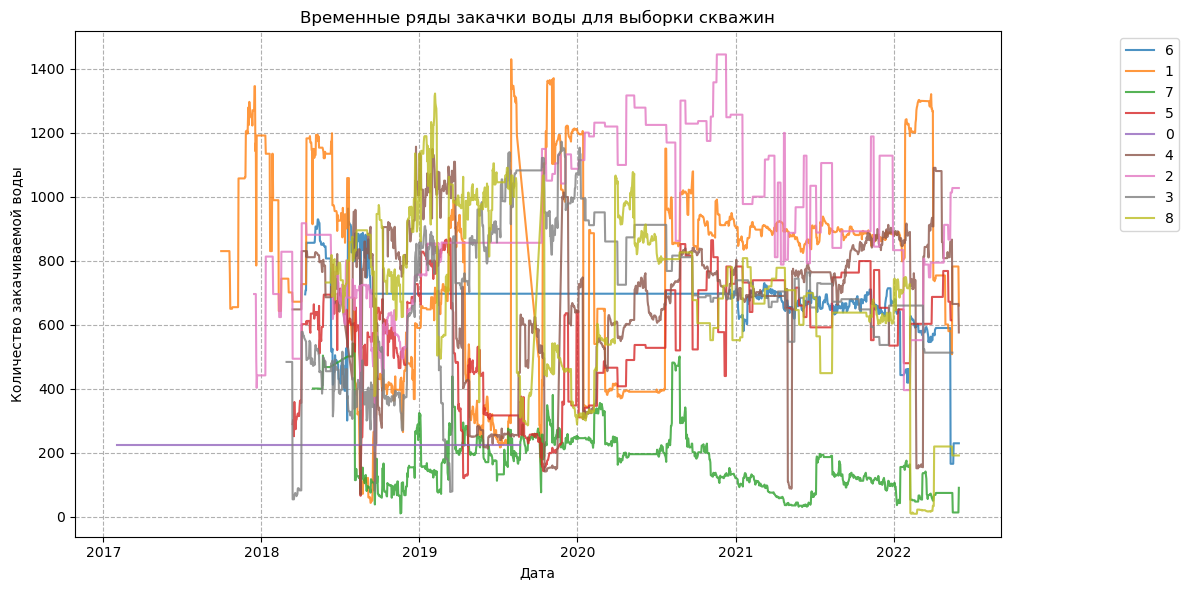

In [25]:
# Выбираем скважины для визуализации
wells = random.sample(list(data_filtered[(data_filtered["CHARWORK"] == "I")]["WELL_NAME"].unique()), 9)

# Создаем фигуру
plt.figure(figsize=(12, 6))

# Цветовая палитра для скважин
colors = plt.cm.tab10.colors  # Используем встроенную цветовую палитру с 10 цветами

# Строим графики для каждой скважины
for i, well in enumerate(wells):
    tmp = data_filtered[(data_filtered["WELL_NAME"] == well) & (data_filtered["CHARWORK"] == "I")]
    plt.plot(
        tmp["MEASURED_IN_DATE"], 
        tmp["INTAKE"], 
        label=well, 
        color=colors[i % len(colors)],  # Циклически выбираем цвет
        alpha=0.8  # Прозрачность линий
    )

# Добавляем сетку, заголовок и подписи осей
plt.grid(ls="--")
plt.title("Временные ряды закачки воды для выборки скважин")
plt.xlabel("Дата")
plt.ylabel("Количество закачиваемой воды")

# Добавляем легенду
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=10)

# Настройка макета для предотвращения перекрытия элементов
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig("plots/water_inj_RN_combined.png", bbox_inches='tight')
plt.show()

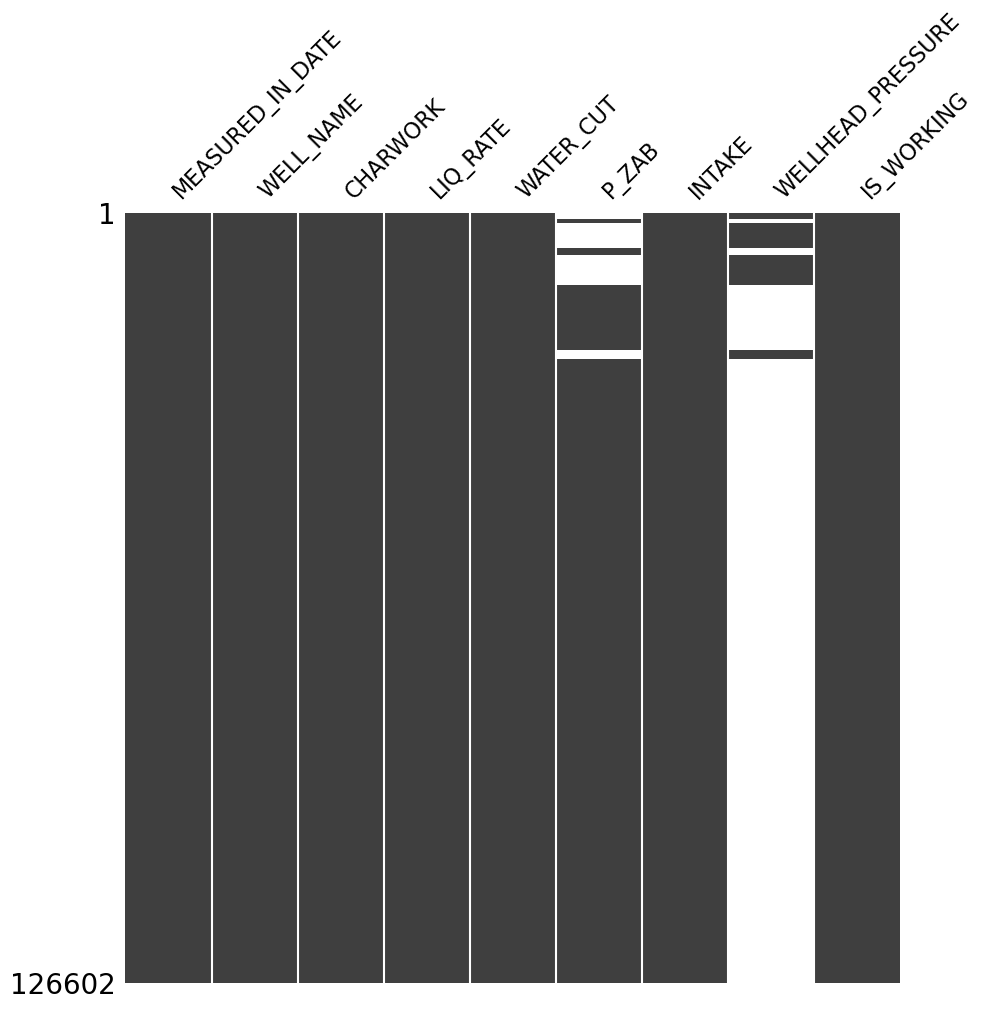

In [26]:
import missingno as msno

# Визуализируем матрицу Missingno
msno.matrix(data_filtered, sparkline=False, figsize=(10, 10))
plt.savefig("plots/missing_RN.png", bbox_inches='tight')
plt.show()

In [17]:
data_filtered.columns

Index(['MEASURED_IN_DATE', 'WELL_NAME', 'CHARWORK', 'LIQ_RATE', 'WATER_CUT',
       'P_ZAB', 'INTAKE', 'WELLHEAD_PRESSURE', 'IS_WORKING'],
      dtype='object')

In [18]:
col_to_drop = [
    "WATER_CUT",
    "P_ZAB",
    "INTAKE",
    "WELLHEAD_PRESSURE",
    "IS_WORKING",
    "CHARWORK"
]

data_prod = data_filtered[data_filtered["CHARWORK"] == "P"].drop(col_to_drop, axis=1)
print(data_prod.shape)
data_prod.isnull().sum()

(115244, 3)


MEASURED_IN_DATE    0
WELL_NAME           0
LIQ_RATE            0
dtype: int64

In [19]:
col_to_drop_1 = [
    "WATER_CUT",
    "P_ZAB",
    "LIQ_RATE",
    "WELLHEAD_PRESSURE",
    "IS_WORKING",
    "CHARWORK"
]

data_inj = data_filtered[data_filtered["CHARWORK"] == "I"].drop(col_to_drop_1, axis=1)
print(data_inj.shape)
data_inj.isnull().sum()

(11358, 3)


MEASURED_IN_DATE    0
WELL_NAME           0
INTAKE              0
dtype: int64

In [20]:
data_prod.describe()

,MEASURED_IN_DATE,LIQ_RATE
count,115244,115244.000000
mean,2021-01-10 21:11:15.117142784,339.798766
min,2016-08-02 00:00:00,1.000000
25%,2020-08-12 00:00:00,115.000000
50%,2021-05-13 00:00:00,235.000000
75%,2021-11-18 00:00:00,492.000000
max,2022-05-31 00:00:00,1622.000000
std,NaN,298.642642


In [21]:
data_inj.describe()

,MEASURED_IN_DATE,INTAKE
count,11358,11358.000000
mean,2020-02-19 19:24:37.654516480,618.961789
min,2017-02-01 00:00:00,10.000000
25%,2018-12-20 00:00:00,319.000000
50%,2020-03-02 12:00:00,663.000000
75%,2021-04-25 00:00:00,852.000000
max,2022-05-31 00:00:00,1444.000000
std,NaN,317.981496


## Пропуски

In [22]:
days_prod = data_prod['MEASURED_IN_DATE'].unique().tolist()
days_inj = data_inj['MEASURED_IN_DATE'].unique().tolist()
print(f"production days: {len(days_prod)}")
print(f"injection days: {len(days_inj)}")

production days: 2122
injection days: 1932


In [23]:
data_prod_sorted = data_prod.sort_values('MEASURED_IN_DATE').set_index('MEASURED_IN_DATE')
data_inj_sorted = data_inj.sort_values('MEASURED_IN_DATE').set_index('MEASURED_IN_DATE')

In [24]:
def fill_gaps(df):
    cols = df.select_dtypes(include='number').columns
    wells = df["WELL_NAME"].unique().tolist()
    result_df = pd.DataFrame()
    for well in wells:
        tmp = df[df["WELL_NAME"] == well].copy()
        # Создаем полный диапазон дат
        full_date_range = pd.date_range(start=tmp.index.min(), end=tmp.index.max(), freq='D')
        # Создаем новый датафрейм с полным диапазоном дат
        tmp = tmp.reindex(full_date_range)
        for col in cols:
            tmp[col] = tmp[col].resample('1D').interpolate()
        tmp['WELL_NAME'] = well
        result_df = pd.concat([result_df, tmp])
    return result_df

In [25]:
data_prod_filled = fill_gaps(data_prod_sorted)

In [26]:
data_prod_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115244 entries, 2016-08-02 to 2022-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  115244 non-null  object 
 1   LIQ_RATE   115244 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.6+ MB


In [27]:
data_prod_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141782 entries, 2016-08-02 to 2022-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  141782 non-null  int64  
 1   LIQ_RATE   141782 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.2 MB


In [28]:
data_inj_filled = fill_gaps(data_inj_sorted)

In [29]:
data_inj_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11358 entries, 2017-02-01 to 2022-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL_NAME  11358 non-null  object 
 1   INTAKE     11358 non-null  float64
dtypes: float64(1), object(1)
memory usage: 266.2+ KB


In [30]:
data_inj_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13334 entries, 2017-02-01 to 2022-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL_NAME  13334 non-null  int64  
 1   INTAKE     13334 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 312.5 KB


In [31]:
days_prod = data_prod_filled.index.unique().tolist()
days_inj = data_inj_filled.index.unique().tolist()
print(f"production days: {len(days_prod)}")
print(f"injection days: {len(days_inj)}")

production days: 2129
injection days: 1946


In [32]:
overlapping_dates = sorted(list(set(days_prod).intersection(set(days_inj))))

In [33]:
len(overlapping_dates)

1946

In [34]:
overlapping_dates[:3]

[Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-02-02 00:00:00'),
 Timestamp('2017-02-03 00:00:00')]

In [35]:
data_prod_overlap = data_prod_filled.loc[overlapping_dates, :]
data_inj_overlap = data_inj_filled.loc[overlapping_dates, :]

# Combine with coords

In [36]:
data_prod_final = data_prod_overlap.reset_index().merge(p_coords.drop(["X2", "Y2", "CHARWORK_unique"], axis=1), on="WELL_NAME").set_index("index")
data_inj_final = data_inj_overlap.reset_index().merge(i_coords.drop(["X2", "Y2", "CHARWORK_unique"], axis=1), on="WELL_NAME").set_index("index")

In [37]:
data_prod_final.head()

,WELL_NAME,LIQ_RATE,COORD_X,COORD_Y
index,,,,
2017-02-01,0,705.0,9485.72,8494.28
2017-02-01,1,579.0,9704.72,8153.28
2017-02-01,2,889.0,10075.72,7153.28
2017-02-01,3,1120.0,10660.72,8462.28
2017-02-01,4,453.0,12260.72,4397.28


In [38]:
data_inj_final.head()

,WELL_NAME,INTAKE,COORD_X,COORD_Y
index,,,,
2017-02-01,0,225.0,8723.72,9233.28
2017-02-02,0,225.0,8723.72,9233.28
2017-02-03,0,225.0,8723.72,9233.28
2017-02-04,0,225.0,8723.72,9233.28
2017-02-05,0,225.0,8723.72,9233.28


# Check dates

In [39]:
# Функция для проверки порядка и пропусков
def check_dates_sequential_and_no_gaps(df, df_name):
    # Получаем уникальные даты и сортируем их
    unique_dates = df.index.drop_duplicates().sort_values()
    
    # Проверка, что уникальные даты отсортированы по возрастанию
    is_sorted = unique_dates.is_monotonic_increasing
    if not is_sorted:
        print(f"Уникальные даты в датафрейме {df_name} не отсортированы по возрастанию.")
        return Falsed

    # Проверка на пропуски
    date_diff = unique_dates.to_series().diff().dropna()
    if not (date_diff == date_diff.iloc[0]).all():
        print(f"В датафрейме {df_name} есть пропуски в датах.")
        return False

    print(f"Даты в датафрейме {df_name} идут по порядку и не имеют пропусков.")
    return True

# Проверка для обоих датафреймов
check_dates_sequential_and_no_gaps(data_prod_final, "prod")
check_dates_sequential_and_no_gaps(data_inj_final, "inj")

Даты в датафрейме prod идут по порядку и не имеют пропусков.
Даты в датафрейме inj идут по порядку и не имеют пропусков.


True

In [40]:
column = "LIQ_RATE"

data = data_prod_final.pivot_table(index=data_prod_final.index, columns="WELL_NAME", values=column)

data.head()

WELL_NAME,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
index,,,,,,,,,,,,,,,,,,,,,
2017-02-01,705.0,579.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-02,684.0,560.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,684.0,560.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-04,684.0,560.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-05,684.0,560.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


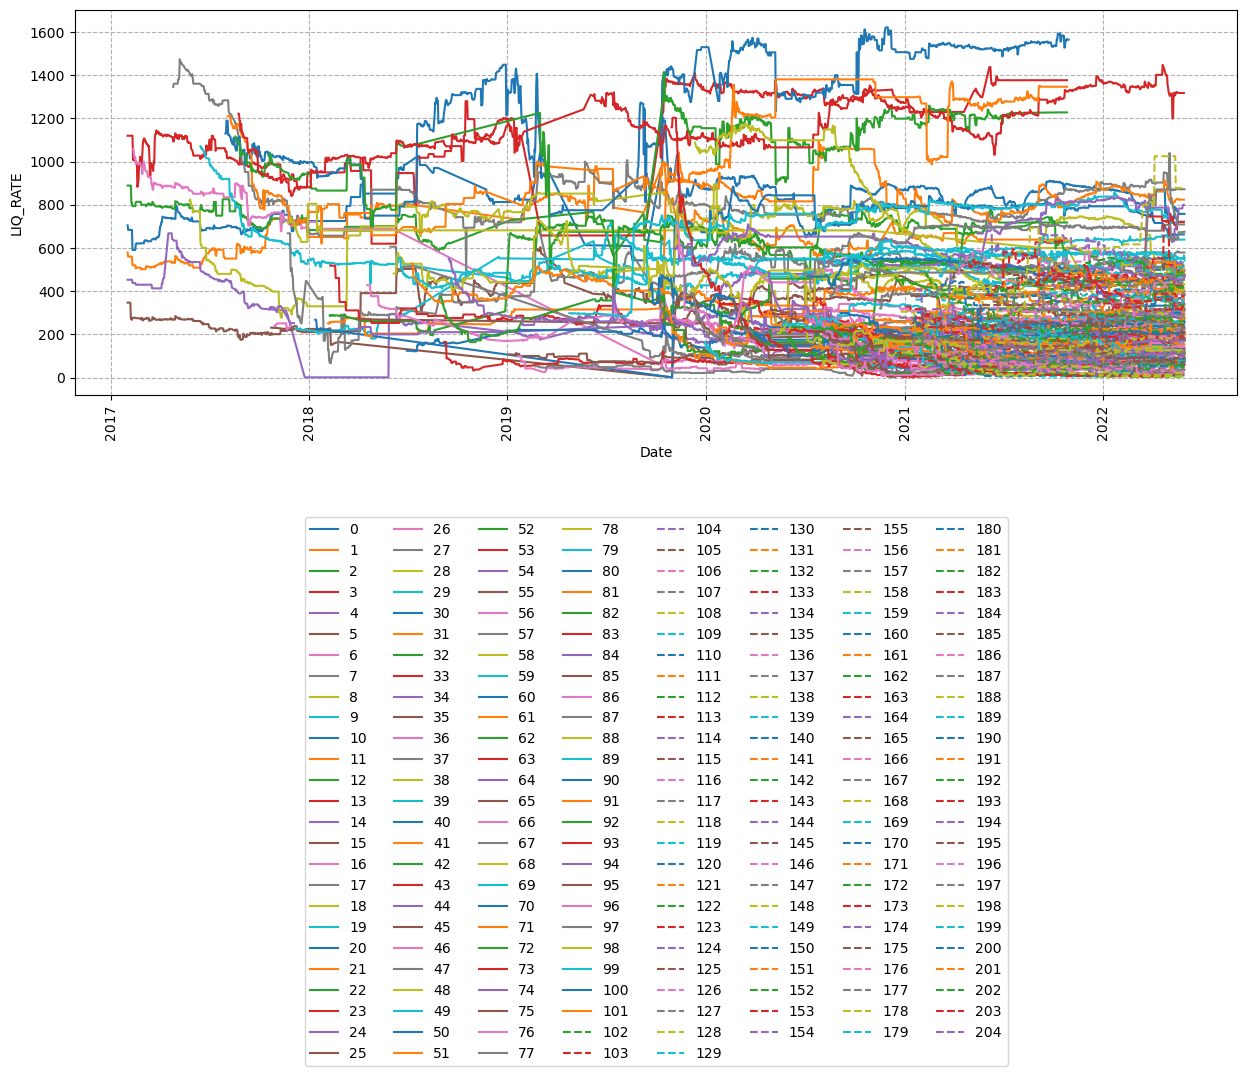

In [41]:
# Define a list of line styles for the plot
ls = ["-"] * (len(data.columns) // 2) + ["--"] * (len(data.columns) // 2 + 1)

plt.figure(figsize=(15, 5))

# Loop over each column in the dataframe
for i, col in enumerate(data.columns):
    # For each column, plot the data with the corresponding line style
    plt.plot(data[col], label=col, ls=ls[i])

# Add a legend to the plot, located at the upper center outside the plot area
leg = plt.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, -0.3), ncol=8)

# Add a grid to the plot with a dashed line style
plt.grid(ls="--")

plt.xlabel("Date")
plt.ylabel(column)
plt.xticks(rotation=90)
plt.show()

In [42]:
column = "INTAKE"

data = data_inj_final.pivot_table(index=data_inj_final.index, columns="WELL_NAME", values=column)

data.head()

WELL_NAME,0,1,2,3,4,5,6,7,8
index,,,,,,,,,
2017-02-01,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-02,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-04,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-05,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


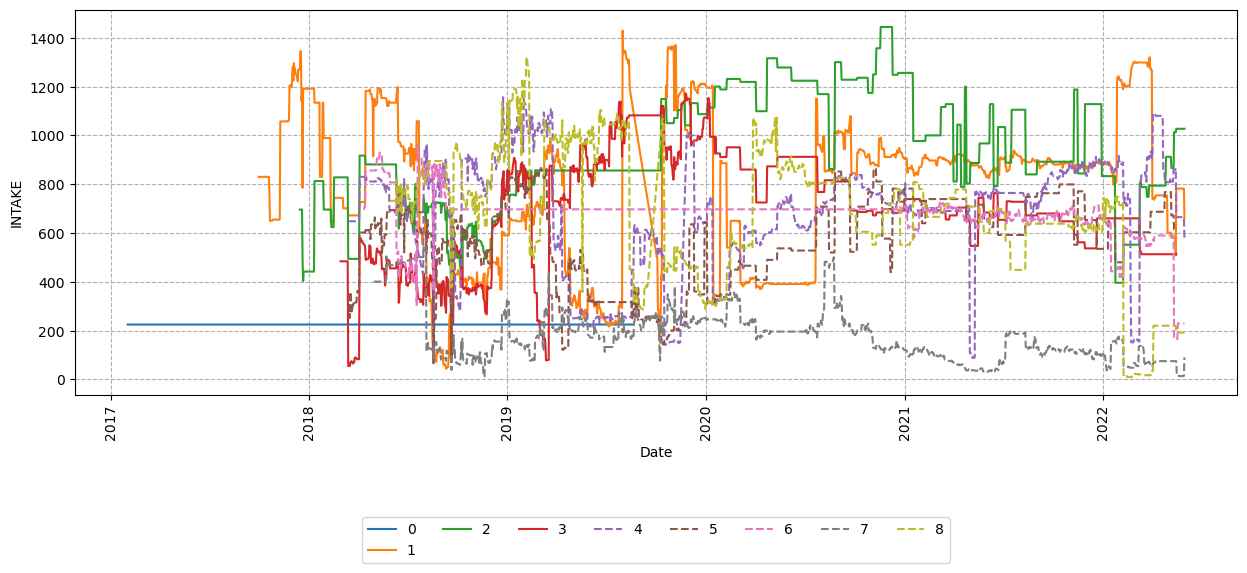

In [43]:
# Define a list of line styles for the plot
ls = ["-"] * (len(data.columns) // 2) + ["--"] * (len(data.columns) // 2 + 1)

plt.figure(figsize=(15, 5))

# Loop over each column in the dataframe
for i, col in enumerate(data.columns):
    # For each column, plot the data with the corresponding line style
    plt.plot(data[col], label=col, ls=ls[i])

# Add a legend to the plot, located at the upper center outside the plot area
leg = plt.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, -0.3), ncol=8)

# Add a grid to the plot with a dashed line style
plt.grid(ls="--")

plt.xlabel("Date")
plt.ylabel(column)
plt.xticks(rotation=90)
plt.show()

In [44]:
list(data_inj_final.index.unique()) == list(data_prod_final.index.unique())

True

# Scale

In [45]:
scaler_target = StandardScaler()
scaler_water = StandardScaler()

data_prod_final_scaled = data_prod_final.copy()
data_inj_final_scaled = data_inj_final.copy()

data_prod_final_scaled.loc[:, ["LIQ_RATE"]] = scaler_target.fit_transform(data_prod_final_scaled.loc[:, ["LIQ_RATE"]])
data_inj_final_scaled.loc[:, ["INTAKE"]] = scaler_water.fit_transform(data_inj_final_scaled.loc[:, ["INTAKE"]])

# Dataset/data splitting

In [46]:
NUM_PROD_WELLS = len(p_wells)
NUM_INJ_WELLS = len(i_wells)

In [47]:
edge_indexes_dicts = []
edge_weights_dicts = []

days = data_prod_final_scaled.index.unique()

for day in days:
    inj_prod_edges = []
    prod_prod_edges = []
    inj_inj_edges=[]

    inj_prod_weights = []
    prod_prod_weights = []
    inj_inj_weights = []

    tmp_prod = data_prod_final_scaled.loc[day, :]
    tmp_inj = data_inj_final_scaled.loc[day, :]

    if isinstance(tmp_inj, pd.Series):
        for _, prod_well in tmp_prod.iterrows():
            distance = np.sqrt((tmp_inj["COORD_X"] - prod_well["COORD_X"])**2\
                                + (tmp_inj["COORD_Y"] - prod_well["COORD_Y"])**2)
            if distance < 1000:
                inj_prod_edges.append([tmp_inj["WELL_NAME"], prod_well["WELL_NAME"]])
                inj_prod_weights.append(distance)

        for _, prod_well_1 in tmp_prod.iterrows():
            for _, prod_well_2 in tmp_prod.iterrows():
                distance = np.sqrt((prod_well_1['COORD_X'] - prod_well_2['COORD_X'])**2\
                                   + (prod_well_1['COORD_Y'] - prod_well_2['COORD_Y'])**2)
                if distance < 1000 and prod_well_1["WELL_NAME"] != prod_well_2["WELL_NAME"]:
                    prod_prod_edges.append([prod_well_1["WELL_NAME"], prod_well_2["WELL_NAME"]])
                    prod_prod_weights.append(distance)
        
    else:
        for _, inj_well in tmp_inj.iterrows():
            for _, prod_well in tmp_prod.iterrows():
                distance = np.sqrt((inj_well["COORD_X"] - prod_well["COORD_X"])**2\
                                   + (inj_well["COORD_Y"] - prod_well["COORD_Y"])**2)
                if distance < 1000:
                    inj_prod_edges.append([inj_well["WELL_NAME"], prod_well["WELL_NAME"]])
                    inj_prod_weights.append(distance)

        for _, prod_well_1 in tmp_prod.iterrows():
            for _, prod_well_2 in tmp_prod.iterrows():
                distance = np.sqrt((prod_well_1['COORD_X'] - prod_well_2['COORD_X'])**2\
                                   + (prod_well_1['COORD_Y'] - prod_well_2['COORD_Y'])**2)
                if distance < 1000 and prod_well_1["WELL_NAME"] != prod_well_2["WELL_NAME"]:
                    prod_prod_edges.append([prod_well_1["WELL_NAME"], prod_well_2["WELL_NAME"]])
                    prod_prod_weights.append(distance)
    
        for _, inj_well_1 in tmp_inj.iterrows():
            for _, inj_well_2 in tmp_inj.iterrows():
                distance = np.sqrt((inj_well_1['COORD_X'] - inj_well_2['COORD_X'])**2\
                                   + (inj_well_1['COORD_Y'] - inj_well_2['COORD_Y'])**2)
                if distance < 1000 and inj_well_1["WELL_NAME"] != inj_well_2["WELL_NAME"]:
                    inj_inj_edges.append([inj_well_1["WELL_NAME"], inj_well_2["WELL_NAME"]])
                    inj_inj_weights.append(distance)
        
    edge_dict = {
        ("inj", "-", "prod"): torch.tensor(inj_prod_edges, dtype=torch.long).t().contiguous() if len(inj_prod_edges) != 0 else torch.tensor([[], []], dtype=torch.long),
        ("prod", "-", "prod"): torch.tensor(prod_prod_edges, dtype=torch.long).t().contiguous() if len(prod_prod_edges) != 0 else torch.tensor([[], []], dtype=torch.long),
        ("inj", "-", "inj"): torch.tensor(inj_inj_edges, dtype=torch.long).t().contiguous() if len(inj_inj_edges) != 0 else torch.tensor([[], []], dtype=torch.long)
    }
    edge_weights_dict = {
        ("inj", "-", "prod"): torch.tensor(inj_prod_weights, dtype=torch.float),
        ("prod", "-", "prod"): torch.tensor(prod_prod_weights, dtype=torch.float),
        ("inj", "-", "inj"): torch.tensor(inj_inj_weights, dtype=torch.float)
    }
    edge_indexes_dicts.append(edge_dict)
    edge_weights_dicts.append(edge_weights_dict)

In [48]:
edge_indexes_dicts[0], edge_weights_dicts[0]

({('inj',
   '-',
   'prod'): tensor([[0],
          [5]]),
  ('prod',
   '-',
   'prod'): tensor([[0, 0, 1, 5],
          [1, 5, 0, 0]]),
  ('inj', '-', 'inj'): tensor([], size=(2, 0), dtype=torch.int64)},
 {('inj', '-', 'prod'): tensor([465.3698]),
  ('prod', '-', 'prod'): tensor([405.2678, 955.9424, 405.2678, 955.9424]),
  ('inj', '-', 'inj'): tensor([])})

In [49]:
num_prod_feat = data_prod_final_scaled.shape[1] - 3
num_inj_feat = data_inj_final_scaled.shape[1] - 3

node_feat_dicts = []
target_dicts = []
work_hours_dicts = []
choke_sizes_dicts = []

for day in days:
    prod_features = np.zeros(shape=(NUM_PROD_WELLS, num_prod_feat))
    inj_features = np.zeros(shape=(NUM_INJ_WELLS, num_inj_feat))
    target = np.zeros(shape=(NUM_PROD_WELLS, 1))

    tmp_prod = data_prod_final_scaled.loc[day, :]
    tmp_inj = data_inj_final_scaled.loc[day, :]

    for _, prod_well in tmp_prod.iterrows():
        i = int(prod_well["WELL_NAME"])
        prod_features[i, :] = prod_well.drop(["COORD_X", "COORD_Y", "WELL_NAME"], axis=0).values

    if isinstance(tmp_inj, pd.Series):
        i = int(inj_well["WELL_NAME"])
        inj_features[i, :] = inj_well.drop(["COORD_X", "COORD_Y", "WELL_NAME"], axis=0).values
    else:
        for _, inj_well in tmp_inj.iterrows():
            i = int(inj_well["WELL_NAME"])
            inj_features[i, :] = inj_well.drop(["COORD_X", "COORD_Y", "WELL_NAME"], axis=0).values

    for _, prod_well in tmp_prod.iterrows():
        i = int(prod_well["WELL_NAME"])
        target[i] = prod_well['LIQ_RATE']

    feat_dict = {
        "prod": torch.tensor(prod_features, dtype=torch.float),
        "inj": torch.tensor(inj_features, dtype=torch.float)
        }
    target_dict = {"prod": torch.tensor(target, dtype=torch.float)}
    
    node_feat_dicts.append(feat_dict)
    target_dicts.append(target_dict)

In [50]:
# print(node_feat_dicts[0])
# print(target_dicts[0])

In [51]:
print(len(edge_weights_dicts), len(node_feat_dicts))

1946 1946


In [52]:
dataset= DynamicHeteroGraphTemporalSignal(
    edge_index_dicts=edge_indexes_dicts,
    edge_weight_dicts=edge_weights_dicts,
    feature_dicts=node_feat_dicts,
    target_dicts=target_dicts,
)

In [53]:
import torch_geometric.transforms as T

# d = T.ToUndirected()(dataset[1000])
# d

# Create sequences

## 1

In [54]:
# # Define sequence lengths
# history_length = 60  # 60 days of historical data
# prediction_length = 30  # Predict 30 days ahead

# # Function to extract sequences
# def extract_sequences_base(dataset, history_length, prediction_length):
#     sequences = []
#     targets = []

#     # Iterate over the dataset with a sliding window
#     for i in range(len(dataset.feature_dicts) - history_length - prediction_length + 1):
#         # Extract historical data (60 days)
#         historical_data = dataset[i:i + history_length]

#         # Extract target data (next 30 days)
#         target_data = dataset[i + history_length:i + history_length + prediction_length]

#         # Extract target values from the target data
#         t_v = [snapshot.y_dict for snapshot in target_data]
#         target_values = torch.cat([t["prod"] for t in t_v], dim=1)
        
#         # Append to sequences and targets
#         sequences.append(historical_data)
#         targets.append(target_values)

#     return sequences, targets

# # Extract sequences and targets
# sequences, targets = extract_sequences_base(dataset, history_length, prediction_length)

In [55]:
# # Define sequence lengths
# history_length = 60  # 60 days of historical data
# prediction_length = 30  # Predict 30 days ahead

# # Function to extract sequences
# def extract_sequences_extra(dataset, history_length, prediction_length):
#     sequences = []
#     targets = []

#     # Iterate over the dataset with a sliding window
#     for i in range(len(dataset.feature_dicts) - history_length - prediction_length + 1):
#         # Extract historical data (60 days)
#         historical_data = dataset[i:i + history_length]

#         # Extract target data (next 30 days)
#         target_data = dataset[i + history_length:i + history_length + prediction_length]

#         # Extract target values from the target data
#         t_v = [snapshot.y_dict for snapshot in target_data]
#         target_values = torch.cat([t["prod"] for t in t_v], dim=1)

#         # Extra data sequences
#         wh_data = torch.cat([snapshot["prod"]["wh"] for snapshot in target_data], dim=1)
#         cs_data = torch.cat([snapshot["prod"]["cs"] for snapshot in target_data], dim=1)

#         full_data = {"main": historical_data, "wh": wh_data, "cs": cs_data}
        
#         # Append to sequences and targets
#         sequences.append(full_data)
#         targets.append(target_values)

#     return sequences, targets

# # Extract sequences and targets
# sequences_extra, targets_extra = extract_sequences_extra(dataset, history_length, prediction_length)

## 2

In [56]:
# Define sequence lengths
history_length = 30  # 30 days of historical data
prediction_length = 30  # Predict 30 days ahead

# Function to extract sequences
def extract_sequences_new_idea(dataset, history_length, prediction_length):
    sequences = []
    targets = []
    target_sequences = []

    # Iterate over the dataset with a sliding window
    for i in range(len(dataset.feature_dicts) - history_length - prediction_length + 1):
        # Extract historical data (60 days)
        historical_data = dataset[i:i + history_length]

        # Extract target data (next 30 days)
        target_data = dataset[i + history_length:i + history_length + prediction_length]

        # Extract target values from the target data
        t_v = [snapshot.y_dict for snapshot in target_data]
        target_values = torch.cat([t["prod"] for t in t_v], dim=1)

        t = historical_data[-1]["prod"]["x"]
        rows_with_non_zero = torch.any(t != 0, dim=1)
        non_zero_row_indices = torch.nonzero(rows_with_non_zero).squeeze()
        indices = non_zero_row_indices
        mask = torch.zeros((NUM_PROD_WELLS, 1), dtype=torch.int)
        mask[indices] = 1
        target_values = target_values * mask
        
        # Append to sequences and targets
        sequences.append(historical_data)
        targets.append(target_values)
        target_sequences.append(target_data)

    return sequences, target_sequences, targets

# Extract sequences and targets
sequences_new, target_sequences, targets_new = extract_sequences_new_idea(dataset, history_length, prediction_length)

In [72]:
len(sequences_new)

1887

# Model

In [57]:
class HeteroGCLSTM_GAT(torch.nn.Module):
    r"""An implementation similar to the Integrated Graph Convolutional Long Short Term
        Memory Cell for heterogeneous Graphs.

        Args:
            in_channels_dict (dict of keys=str and values=int): Dimension of each node's input features.
            out_channels (int): Number of output features.
            metadata (tuple): Metadata on node types and edge types in the graphs. Can be generated via PyG method
                :obj:`snapshot.metadata()` where snapshot is a single HeteroData object.
            bias (bool, optional): If set to :obj:`False`, the layer will not learn
                an additive bias. (default: :obj:`True`)
    """

    def __init__(
            self,
            in_channels_dict: dict,
            out_channels: int,
            metadata: tuple,
            bias: bool = True
    ):
        super(HeteroGCLSTM_GAT, self).__init__()

        self.in_channels_dict = in_channels_dict
        self.out_channels = out_channels
        self.metadata = metadata
        self.bias = bias
        self._create_parameters_and_layers()
        self._set_parameters()

    def _create_input_gate_parameters_and_layers(self):
        self.conv_i = HeteroConv({edge_type: GATConv(in_channels=(-1, -1),
                                                     out_channels=self.out_channels,
                                                     heads=1,
                                                     # concat=False,
                                                     # edge_dim=1,
                                                     bias=self.bias,
                                                     add_self_loops=False) for edge_type in self.metadata[1]})

        self.W_i = nn.ParameterDict({node_type: Parameter(torch.Tensor(in_channels, self.out_channels))
                    for node_type, in_channels in self.in_channels_dict.items()})
        self.b_i = nn.ParameterDict({node_type: Parameter(torch.Tensor(1, self.out_channels))
                    for node_type in self.in_channels_dict})

    def _create_forget_gate_parameters_and_layers(self):
        self.conv_f = HeteroConv({edge_type: GATConv(in_channels=(-1, -1),
                                                     out_channels=self.out_channels,
                                                     heads=1,
                                                     # concat=False,
                                                     # edge_dim=1,
                                                     bias=self.bias,
                                                     add_self_loops=False) for edge_type in self.metadata[1]})

        self.W_f = nn.ParameterDict({node_type: Parameter(torch.Tensor(in_channels, self.out_channels))
                    for node_type, in_channels in self.in_channels_dict.items()})
        self.b_f = nn.ParameterDict({node_type: Parameter(torch.Tensor(1, self.out_channels))
                    for node_type in self.in_channels_dict})

    def _create_cell_state_parameters_and_layers(self):
        self.conv_c = HeteroConv({edge_type: GATConv(in_channels=(-1, -1),
                                                     out_channels=self.out_channels,
                                                     heads=1,
                                                     # concat=False,
                                                     # edge_dim=1,
                                                     bias=self.bias,
                                                     add_self_loops=False) for edge_type in self.metadata[1]})

        self.W_c = nn.ParameterDict({node_type: Parameter(torch.Tensor(in_channels, self.out_channels))
                    for node_type, in_channels in self.in_channels_dict.items()})
        self.b_c = nn.ParameterDict({node_type: Parameter(torch.Tensor(1, self.out_channels))
                    for node_type in self.in_channels_dict})

    def _create_output_gate_parameters_and_layers(self):
        self.conv_o = HeteroConv({edge_type: GATConv(in_channels=(-1, -1),
                                                     out_channels=self.out_channels,
                                                     heads=1,
                                                     # concat=False,
                                                     # edge_dim=1,
                                                     bias=self.bias,
                                                     add_self_loops=False) for edge_type in self.metadata[1]})

        self.W_o = nn.ParameterDict({node_type: Parameter(torch.Tensor(in_channels, self.out_channels))
                    for node_type, in_channels in self.in_channels_dict.items()})
        self.b_o = nn.ParameterDict({node_type: Parameter(torch.Tensor(1, self.out_channels))
                    for node_type in self.in_channels_dict})

    def _create_parameters_and_layers(self):
        self._create_input_gate_parameters_and_layers()
        self._create_forget_gate_parameters_and_layers()
        self._create_cell_state_parameters_and_layers()
        self._create_output_gate_parameters_and_layers()

    def _set_parameters(self):
        for key in self.W_i:
            glorot(self.W_i[key])
        for key in self.W_f:
            glorot(self.W_f[key])
        for key in self.W_c:
            glorot(self.W_c[key])
        for key in self.W_o:
            glorot(self.W_o[key])
        for key in self.b_i:
            glorot(self.b_i[key])
        for key in self.b_f:
            glorot(self.b_f[key])
        for key in self.b_c:
            glorot(self.b_c[key])
        for key in self.b_o:
            glorot(self.b_o[key])

    def _set_hidden_state(self, x_dict, h_dict):
        if h_dict is None:
            h_dict = {node_type: torch.zeros(X.shape[0], self.out_channels) for node_type, X in x_dict.items()}
        return h_dict

    def _set_cell_state(self, x_dict, c_dict):
        if c_dict is None:
            c_dict = {node_type: torch.zeros(X.shape[0], self.out_channels) for node_type, X in x_dict.items()}
        return c_dict

    def _calculate_input_gate(self, x_dict, edge_index_dict, h_dict, c_dict):
        i_dict = {node_type: torch.matmul(X, self.W_i[node_type]) for node_type, X in x_dict.items()}
        conv_i = self.conv_i(h_dict, edge_index_dict)
        i_dict = {node_type: I + conv_i[node_type] for node_type, I in i_dict.items()}
        i_dict = {node_type: I + self.b_i[node_type] for node_type, I in i_dict.items()}
        i_dict = {node_type: torch.sigmoid(I) for node_type, I in i_dict.items()}
        return i_dict

    def _calculate_forget_gate(self, x_dict, edge_index_dict, h_dict, c_dict):
        f_dict = {node_type: torch.matmul(X, self.W_f[node_type]) for node_type, X in x_dict.items()}
        conv_f = self.conv_f(h_dict, edge_index_dict)
        f_dict = {node_type: F + conv_f[node_type] for node_type, F in f_dict.items()}
        f_dict = {node_type: F + self.b_f[node_type] for node_type, F in f_dict.items()}
        f_dict = {node_type: torch.sigmoid(F) for node_type, F in f_dict.items()}
        return f_dict

    def _calculate_cell_state(self, x_dict, edge_index_dict, h_dict, c_dict, i_dict, f_dict):
        t_dict = {node_type: torch.matmul(X, self.W_c[node_type]) for node_type, X in x_dict.items()}
        conv_c = self.conv_c(h_dict, edge_index_dict)
        t_dict = {node_type: T + conv_c[node_type] for node_type, T in t_dict.items()}
        t_dict = {node_type: T + self.b_c[node_type] for node_type, T in t_dict.items()}
        t_dict = {node_type: torch.tanh(T) for node_type, T in t_dict.items()}
        c_dict = {node_type: f_dict[node_type] * C + i_dict[node_type] * t_dict[node_type] for node_type, C in c_dict.items()}
        return c_dict

    def _calculate_output_gate(self, x_dict, edge_index_dict, h_dict, c_dict):
        o_dict = {node_type: torch.matmul(X, self.W_o[node_type]) for node_type, X in x_dict.items()}
        conv_o = self.conv_o(h_dict, edge_index_dict)
        o_dict = {node_type: O + conv_o[node_type] for node_type, O in o_dict.items()}
        o_dict = {node_type: O + self.b_o[node_type] for node_type, O in o_dict.items()}
        o_dict = {node_type: torch.sigmoid(O) for node_type, O in o_dict.items()}
        return o_dict

    def _calculate_hidden_state(self, o_dict, c_dict):
        h_dict = {node_type: o_dict[node_type] * torch.tanh(C) for node_type, C in c_dict.items()}
        return h_dict

    def forward(
        self,
        x_dict,
        edge_index_dict,
        h_dict=None,
        c_dict=None,
    ):
        """
        Making a forward pass. If the hidden state and cell state
        matrix dicts are not present when the forward pass is called these are
        initialized with zeros.

        Arg types:
            * **x_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensors)* - Node features dicts. Can
                be obtained via PyG method :obj:`snapshot.x_dict` where snapshot is a single HeteroData object.
            * **edge_index_dict** *(Dictionary where keys=Tuples and values=PyTorch Long Tensors)* - Graph edge type
                and index dicts. Can be obtained via PyG method :obj:`snapshot.edge_index_dict`.
            * **h_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensor, optional)* - Node type and
                hidden state matrix dict for all nodes.
            * **c_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensor, optional)* - Node type and
                cell state matrix dict for all nodes.

        Return types:
            * **h_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensor)* - Node type and
                hidden state matrix dict for all nodes.
            * **c_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensor)* - Node type and
                cell state matrix dict for all nodes.
        """

        h_dict = self._set_hidden_state(x_dict, h_dict)
        c_dict = self._set_cell_state(x_dict, c_dict)
        i_dict = self._calculate_input_gate(x_dict, edge_index_dict, h_dict, c_dict)
        f_dict = self._calculate_forget_gate(x_dict, edge_index_dict, h_dict, c_dict)
        c_dict = self._calculate_cell_state(x_dict, edge_index_dict, h_dict, c_dict, i_dict, f_dict)
        o_dict = self._calculate_output_gate(x_dict, edge_index_dict, h_dict, c_dict)
        h_dict = self._calculate_hidden_state(o_dict, c_dict)
        return h_dict, c_dict

In [58]:
class HeteroGCLSTM_SAGE(torch.nn.Module):
    r"""An implementation similar to the Integrated Graph Convolutional Long Short Term
        Memory Cell for heterogeneous Graphs.

        Args:
            in_channels_dict (dict of keys=str and values=int): Dimension of each node's input features.
            out_channels (int): Number of output features.
            metadata (tuple): Metadata on node types and edge types in the graphs. Can be generated via PyG method
                :obj:`snapshot.metadata()` where snapshot is a single HeteroData object.
            bias (bool, optional): If set to :obj:`False`, the layer will not learn
                an additive bias. (default: :obj:`True`)
    """

    def __init__(
            self,
            in_channels_dict: dict,
            out_channels: int,
            metadata: tuple,
            bias: bool = True
    ):
        super(HeteroGCLSTM_SAGE, self).__init__()

        self.in_channels_dict = in_channels_dict
        self.out_channels = out_channels
        self.metadata = metadata
        self.bias = bias
        self._create_parameters_and_layers()
        self._set_parameters()

    def _create_input_gate_parameters_and_layers(self):
        self.conv_i = HeteroConv({edge_type: SAGEConv(in_channels=(-1, -1),
                                                      out_channels=self.out_channels,
                                                      bias=self.bias) for edge_type in self.metadata[1]})

        self.W_i = nn.ParameterDict({node_type: Parameter(torch.Tensor(in_channels, self.out_channels))
                    for node_type, in_channels in self.in_channels_dict.items()})
        self.b_i = nn.ParameterDict({node_type: Parameter(torch.Tensor(1, self.out_channels))
                    for node_type in self.in_channels_dict})

    def _create_forget_gate_parameters_and_layers(self):
        self.conv_f = HeteroConv({edge_type: SAGEConv(in_channels=(-1, -1),
                                                      out_channels=self.out_channels,
                                                      bias=self.bias) for edge_type in self.metadata[1]})

        self.W_f = nn.ParameterDict({node_type: Parameter(torch.Tensor(in_channels, self.out_channels))
                    for node_type, in_channels in self.in_channels_dict.items()})
        self.b_f = nn.ParameterDict({node_type: Parameter(torch.Tensor(1, self.out_channels))
                    for node_type in self.in_channels_dict})

    def _create_cell_state_parameters_and_layers(self):
        self.conv_c = HeteroConv({edge_type: SAGEConv(in_channels=(-1, -1),
                                                      out_channels=self.out_channels,
                                                      bias=self.bias) for edge_type in self.metadata[1]})

        self.W_c = nn.ParameterDict({node_type: Parameter(torch.Tensor(in_channels, self.out_channels))
                    for node_type, in_channels in self.in_channels_dict.items()})
        self.b_c = nn.ParameterDict({node_type: Parameter(torch.Tensor(1, self.out_channels))
                    for node_type in self.in_channels_dict})

    def _create_output_gate_parameters_and_layers(self):
        self.conv_o = HeteroConv({edge_type: SAGEConv(in_channels=(-1, -1),
                                                      out_channels=self.out_channels,
                                                      bias=self.bias) for edge_type in self.metadata[1]})

        self.W_o = nn.ParameterDict({node_type: Parameter(torch.Tensor(in_channels, self.out_channels))
                    for node_type, in_channels in self.in_channels_dict.items()})
        self.b_o = nn.ParameterDict({node_type: Parameter(torch.Tensor(1, self.out_channels))
                    for node_type in self.in_channels_dict})

    def _create_parameters_and_layers(self):
        self._create_input_gate_parameters_and_layers()
        self._create_forget_gate_parameters_and_layers()
        self._create_cell_state_parameters_and_layers()
        self._create_output_gate_parameters_and_layers()

    def _set_parameters(self):
        for key in self.W_i:
            glorot(self.W_i[key])
        for key in self.W_f:
            glorot(self.W_f[key])
        for key in self.W_c:
            glorot(self.W_c[key])
        for key in self.W_o:
            glorot(self.W_o[key])
        for key in self.b_i:
            glorot(self.b_i[key])
        for key in self.b_f:
            glorot(self.b_f[key])
        for key in self.b_c:
            glorot(self.b_c[key])
        for key in self.b_o:
            glorot(self.b_o[key])

    def _set_hidden_state(self, x_dict, h_dict):
        if h_dict is None:
            h_dict = {node_type: torch.zeros(X.shape[0], self.out_channels) for node_type, X in x_dict.items()}
        return h_dict

    def _set_cell_state(self, x_dict, c_dict):
        if c_dict is None:
            c_dict = {node_type: torch.zeros(X.shape[0], self.out_channels) for node_type, X in x_dict.items()}
        return c_dict

    def _calculate_input_gate(self, x_dict, edge_index_dict, h_dict, c_dict):
        i_dict = {node_type: torch.matmul(X, self.W_i[node_type]) for node_type, X in x_dict.items()}
        conv_i = self.conv_i(h_dict, edge_index_dict)
        i_dict = {node_type: I + conv_i[node_type] for node_type, I in i_dict.items()}
        i_dict = {node_type: I + self.b_i[node_type] for node_type, I in i_dict.items()}
        i_dict = {node_type: torch.sigmoid(I) for node_type, I in i_dict.items()}
        return i_dict

    def _calculate_forget_gate(self, x_dict, edge_index_dict, h_dict, c_dict):
        f_dict = {node_type: torch.matmul(X, self.W_f[node_type]) for node_type, X in x_dict.items()}
        conv_f = self.conv_f(h_dict, edge_index_dict)
        f_dict = {node_type: F + conv_f[node_type] for node_type, F in f_dict.items()}
        f_dict = {node_type: F + self.b_f[node_type] for node_type, F in f_dict.items()}
        f_dict = {node_type: torch.sigmoid(F) for node_type, F in f_dict.items()}
        return f_dict

    def _calculate_cell_state(self, x_dict, edge_index_dict, h_dict, c_dict, i_dict, f_dict):
        t_dict = {node_type: torch.matmul(X, self.W_c[node_type]) for node_type, X in x_dict.items()}
        conv_c = self.conv_c(h_dict, edge_index_dict)
        t_dict = {node_type: T + conv_c[node_type] for node_type, T in t_dict.items()}
        t_dict = {node_type: T + self.b_c[node_type] for node_type, T in t_dict.items()}
        t_dict = {node_type: torch.tanh(T) for node_type, T in t_dict.items()}
        c_dict = {node_type: f_dict[node_type] * C + i_dict[node_type] * t_dict[node_type] for node_type, C in c_dict.items()}
        return c_dict

    def _calculate_output_gate(self, x_dict, edge_index_dict, h_dict, c_dict):
        o_dict = {node_type: torch.matmul(X, self.W_o[node_type]) for node_type, X in x_dict.items()}
        conv_o = self.conv_o(h_dict, edge_index_dict)
        o_dict = {node_type: O + conv_o[node_type] for node_type, O in o_dict.items()}
        o_dict = {node_type: O + self.b_o[node_type] for node_type, O in o_dict.items()}
        o_dict = {node_type: torch.sigmoid(O) for node_type, O in o_dict.items()}
        return o_dict

    def _calculate_hidden_state(self, o_dict, c_dict):
        h_dict = {node_type: o_dict[node_type] * torch.tanh(C) for node_type, C in c_dict.items()}
        return h_dict

    def forward(
        self,
        x_dict,
        edge_index_dict,
        h_dict=None,
        c_dict=None,
    ):
        """
        Making a forward pass. If the hidden state and cell state
        matrix dicts are not present when the forward pass is called these are
        initialized with zeros.

        Arg types:
            * **x_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensors)* - Node features dicts. Can
                be obtained via PyG method :obj:`snapshot.x_dict` where snapshot is a single HeteroData object.
            * **edge_index_dict** *(Dictionary where keys=Tuples and values=PyTorch Long Tensors)* - Graph edge type
                and index dicts. Can be obtained via PyG method :obj:`snapshot.edge_index_dict`.
            * **h_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensor, optional)* - Node type and
                hidden state matrix dict for all nodes.
            * **c_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensor, optional)* - Node type and
                cell state matrix dict for all nodes.

        Return types:
            * **h_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensor)* - Node type and
                hidden state matrix dict for all nodes.
            * **c_dict** *(Dictionary where keys=Strings and values=PyTorch Float Tensor)* - Node type and
                cell state matrix dict for all nodes.
        """

        h_dict = self._set_hidden_state(x_dict, h_dict)
        c_dict = self._set_cell_state(x_dict, c_dict)
        i_dict = self._calculate_input_gate(x_dict, edge_index_dict, h_dict, c_dict)
        f_dict = self._calculate_forget_gate(x_dict, edge_index_dict, h_dict, c_dict)
        c_dict = self._calculate_cell_state(x_dict, edge_index_dict, h_dict, c_dict, i_dict, f_dict)
        o_dict = self._calculate_output_gate(x_dict, edge_index_dict, h_dict, c_dict)
        h_dict = self._calculate_hidden_state(o_dict, c_dict)
        return h_dict, c_dict

# Meta

In [59]:
input_dims = {"prod": num_prod_feat, "inj": num_inj_feat}
meta = dataset[0].metadata()

# Train (test)

In [60]:
class MyModel_basic(nn.Module):

    def __init__(
            self,
            input_size: dict,
            hidden_size: int,
            out_steps: int,
            node_type_to_pred: str,
            metadata: tuple,
            bias: bool=True,
            n_layers: int = 1,
        ):
        super().__init__()
        self.n_layers = n_layers
        self.node_type_to_pred = node_type_to_pred
        self.hidden_size = hidden_size
        self.heterogcnlstm_layer = HeteroGCLSTM_SAGE(input_size, hidden_size, metadata, bias)
        self.linear = nn.Linear(in_features=hidden_size, out_features=out_steps)

    def forward(self, graph_seq):
        n_steps = sum(1 for _ in graph_seq)
        h_dict = {node_type: torch.zeros(X.shape[0], self.hidden_size, device=next(self.parameters()).device) for node_type, X in graph_seq[0].x_dict.items()}
        c_dict = {node_type: torch.zeros(X.shape[0], self.hidden_size, device=next(self.parameters()).device) for node_type, X in graph_seq[0].x_dict.items()}
        outputs = []

        for t in range(n_steps):
            data = graph_seq[t]
            h_dict, c_dict = self.heterogcnlstm_layer.forward(
                data.x_dict, data.edge_index_dict, h_dict, c_dict
            )
            outputs.append(h_dict[self.node_type_to_pred])

        return self.linear(h_dict[self.node_type_to_pred]), outputs

In [61]:
class MyModel_extra(nn.Module):

    def __init__(
            self,
            input_size: dict,
            hidden_size: int,
            out_steps: int,
            node_type_to_pred: str,
            metadata: tuple,
            bias: bool=True,
            n_layers: int = 1,
        ):
        super().__init__()
        self.n_layers = n_layers
        self.node_type_to_pred = node_type_to_pred
        self.hidden_size = hidden_size
        self.heterogcnlstm_layer = HeteroGCLSTM_SAGE(input_size, hidden_size, metadata, bias)
        self.linear_extra_1 = nn.Linear(in_features=out_steps, out_features=16)
        self.linear_extra_2 = nn.Linear(in_features=out_steps, out_features=16)
        self.linear = nn.Linear(in_features=hidden_size * 3, out_features=out_steps)

    def forward(self, graph_seq, e_1, e_2):
        n_steps = sum(1 for _ in graph_seq)
        h_dict = {node_type: torch.zeros(X.shape[0], self.hidden_size, device=next(self.parameters()).device) for node_type, X in graph_seq[0].x_dict.items()}
        c_dict = {node_type: torch.zeros(X.shape[0], self.hidden_size, device=next(self.parameters()).device) for node_type, X in graph_seq[0].x_dict.items()}
        outputs = []

        for t in range(n_steps):
            data = graph_seq[t]
            h_dict, c_dict = self.heterogcnlstm_layer.forward(
                data.x_dict, data.edge_index_dict, h_dict, c_dict
            )
            outputs.append(h_dict[self.node_type_to_pred])

        extra_1 = self.linear_extra_1(e_1)
        extra_2 = self.linear_extra_2(e_2)

        out = self.linear(torch.cat([h_dict[self.node_type_to_pred], extra_1, extra_2], dim=1))
        
        return out, outputs

In [62]:
class MyModel_autoregressive(nn.Module):

    def __init__(
            self,
            input_size: dict,
            hidden_size: int,
            out_size: int,
            out_steps: int,
            node_type_to_pred: str,
            metadata: tuple,
            bias: bool=True,
            n_layers: int = 1
        ):
        super().__init__()
        self.n_layers = n_layers
        self.out_steps = out_steps
        self.node_type_to_pred = node_type_to_pred
        self.hidden_size = hidden_size
        self.heterogcnlstm_layer = HeteroGCLSTM_SAGE(input_size, hidden_size, metadata, bias)
        self.linear_1 = {
            node_type: nn.Linear(
                in_features=hidden_size,
                out_features=input_size[node_type]
            ) for node_type, dim in input_size.items()
        } 
        self.linear_2 = nn.Linear(in_features=hidden_size, out_features=out_size)

    def warmup(self, graph_seq):
        n_steps = sum(1 for _ in graph_seq)
        h_dict = {node_type: torch.zeros(X.shape[0], self.hidden_size) for node_type, X in graph_seq[0].x_dict.items()}
        c_dict = {node_type: torch.zeros(X.shape[0], self.hidden_size) for node_type, X in graph_seq[0].x_dict.items()}
        edges = []
        
        for t in range(n_steps):
            data = graph_seq[t]
            h_dict, c_dict = self.heterogcnlstm_layer.forward(
                data.x_dict, data.edge_index_dict, h_dict, c_dict
            )
            edges.append(data.edge_index_dict)

        pred = {node_type: self.linear_1[node_type](X) for node_type, X in h_dict.items()}
        pred_to_out = self.linear_2(h_dict[self.node_type_to_pred])
        return pred, edges[-1], h_dict, c_dict, pred_to_out

    def forward(self, graph_seq):

        predictions = []
        prediction, edges, h, c, prediction_to_out = self.warmup(graph_seq)
        predictions.append(prediction_to_out)
        
        for t in range(1, self.out_steps):
            x = prediction
            h, c = self.heterogcnlstm_layer(x, edges, h, c)
            prediction = {node_type: self.linear_1[node_type](X) for node_type, X in h.items()}
            prediction_to_out = self.linear_2(h[self.node_type_to_pred])
            predictions.append(prediction_to_out)

        return torch.stack(predictions, dim=1).squeeze()

In [63]:
model_basic = MyModel_basic(
    input_size=input_dims,
    hidden_size=16,
    out_steps=30,
    node_type_to_pred="prod",
    metadata=dataset[0].metadata()
)

In [64]:
model_extra = MyModel_extra(
    input_size=input_dims,
    hidden_size=16,
    out_steps=30,
    node_type_to_pred="prod",
    metadata=dataset[0].metadata()
)

In [65]:
model_autoreg = MyModel_autoregressive(
    input_size=input_dims,
    hidden_size=16,
    out_size=1,
    out_steps=30,
    node_type_to_pred="prod",
    metadata=dataset[0].metadata()
)

# New idea models

При применении сглаживания скользящим средним с окном размера 60 нулевых значений практический не остается. Соответственно, при использовании модели можно с помощью маски оставлять ненулевым в output прогноз только для тех узлов (скважин), которые были в последнем входном графе. Затем для таргета так же скрывать лишние узлы (скважины) для подсчета ошибки.

- Попробовать добавить поверх линейного слоя сигмоид для того, чтобы значения выхода были в диапазоне от 0 до 1 (не желательно)

In [66]:
class HeteroGCLSTMEncoder(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers):
        super(HeteroGCLSTMEncoder, self).__init__()
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([
            HeteroGCLSTM_SAGE(in_channels_dict, out_channels, metadata) for _ in range(num_layers)
        ])

    def forward(self, x_dict_seq, edge_index_dict_seq):
        h_dict = None
        c_dict = None
        for t in range(len(x_dict_seq)):
            x_dict = x_dict_seq[t]
            edge_index_dict = edge_index_dict_seq[t]
            for lstm_cell in self.lstm_cells:
                h_dict, c_dict = lstm_cell(x_dict, edge_index_dict, h_dict, c_dict)
        return h_dict, c_dict

class HeteroGCLSTMDecoder(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers, output_node_type):
        super(HeteroGCLSTMDecoder, self).__init__()
        self.num_layers = num_layers
        self.output_node_type = output_node_type
        self.lstm_cells = nn.ModuleList([
            HeteroGCLSTM_SAGE(in_channels_dict, out_channels, metadata) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(out_channels, 1)  # Assuming we predict a single feature
        self.projection_layers = nn.ModuleDict({
            node_type: nn.Linear(out_channels, in_channels) for node_type, in_channels in in_channels_dict.items()
        })

    def forward(self, x_dict_seq, edge_index_dict_seq, h_dict, c_dict, future_steps, teacher_forcing=False, true_future_seq=None):
        predictions = []
        current_input = x_dict_seq[-1]  # Initial input for the decoder
        current_edge_index = edge_index_dict_seq[-1]  # Initial edge index for the decoder

        for step in range(future_steps):
            for lstm_cell in self.lstm_cells:
                h_dict, c_dict = lstm_cell(current_input, current_edge_index, h_dict, c_dict)
            projected_input = {node_type: self.projection_layers[node_type](h_dict[node_type]) for node_type in h_dict}
            prediction = self.output_layer(h_dict[self.output_node_type])
            predictions.append(prediction)

            current_input = projected_input

        return predictions

class HeteroGCLSTMSeq2Seq(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers, output_node_type):
        super(HeteroGCLSTMSeq2Seq, self).__init__()
        self.encoder = HeteroGCLSTMEncoder(in_channels_dict, out_channels, metadata, num_layers)
        self.decoder = HeteroGCLSTMDecoder(in_channels_dict, out_channels, metadata, num_layers, output_node_type)

    def forward(self, x_dict_seq, edge_index_dict_seq, future_steps):
        h_dict, c_dict = self.encoder(x_dict_seq, edge_index_dict_seq)
        predictions = self.decoder(x_dict_seq, edge_index_dict_seq, h_dict, c_dict, future_steps)
        return torch.stack(predictions, dim=1).squeeze()

In [67]:
class HeteroGCLSTMEncoder_new(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers):
        super(HeteroGCLSTMEncoder_new, self).__init__()
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([
            HeteroGCLSTM_SAGE(in_channels_dict, out_channels, metadata) for _ in range(num_layers)
        ])

    def forward(self, x_dict_seq, edge_index_dict_seq):
        h_dict = None
        c_dict = None
        for t in range(len(x_dict_seq)):
            x_dict = x_dict_seq[t]
            edge_index_dict = edge_index_dict_seq[t]
            for lstm_cell in self.lstm_cells:
                h_dict, c_dict = lstm_cell(x_dict, edge_index_dict, h_dict, c_dict)
        return h_dict, c_dict, edge_index_dict_seq[-1]

class HeteroGCLSTMDecoder_new(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers, output_node_type):
        super(HeteroGCLSTMDecoder_new, self).__init__()
        self.num_layers = num_layers
        self.output_node_type = output_node_type
        self.lstm_cells = nn.ModuleList([
            HeteroGCLSTM_SAGE(in_channels_dict, out_channels, metadata) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(out_channels, 1)  # Assuming we predict a single feature

    def forward(self, x_dict_seq, edge_index_dict, h_dict, c_dict, future_steps):
        predictions = []

        current_input = x_dict_seq[0]
        current_edge_index = edge_index_dict

        for step in range(future_steps):
            for lstm_cell in self.lstm_cells:
                h_dict, c_dict = lstm_cell(current_input, current_edge_index, h_dict, c_dict)
            prediction = self.output_layer(h_dict[self.output_node_type])
            if step < (future_steps - 1):
                tmp = x_dict_seq[step + 1]["prod"]
                tmp[:, 2] = prediction.squeeze().detach()
                decoder_input = {"prod": tmp, "inj": x_dict_seq[step + 1]["inj"]}
                # decoder_input = x_dict_seq[step + 1].copy()
                # pred = prediction.squeeze().clone().detach()
                # decoder_input[self.output_node_type][:, 2] = pred
                current_input = decoder_input
            predictions.append(prediction)

        return predictions

class HeteroGCLSTMSeq2Seq_new(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers, output_node_type):
        super(HeteroGCLSTMSeq2Seq_new, self).__init__()
        self.encoder = HeteroGCLSTMEncoder_new(in_channels_dict, out_channels, metadata, num_layers)
        self.decoder = HeteroGCLSTMDecoder_new(in_channels_dict, out_channels, metadata, num_layers, output_node_type)

    def forward(self, x_dict_seq, edge_index_dict_seq, x_dict_seq_target, future_steps):
        h_dict, c_dict, edge_index_dict = self.encoder(x_dict_seq, edge_index_dict_seq)
        predictions = self.decoder(x_dict_seq_target, edge_index_dict, h_dict, c_dict, future_steps)
        return torch.stack(predictions, dim=1).squeeze()

In [68]:
class HeteroGCLSTMEncoder_new_GAT(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers):
        super(HeteroGCLSTMEncoder_new_GAT, self).__init__()
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([
            HeteroGCLSTM_GAT(in_channels_dict, out_channels, metadata) for _ in range(num_layers)
        ])

    def forward(self, x_dict_seq, edge_index_dict_seq):
        h_dict = None
        c_dict = None
        for t in range(len(x_dict_seq)):
            x_dict = x_dict_seq[t]
            edge_index_dict = edge_index_dict_seq[t]
            for lstm_cell in self.lstm_cells:
                h_dict, c_dict = lstm_cell(x_dict, edge_index_dict, h_dict, c_dict)
        return h_dict, c_dict, edge_index_dict_seq[-1]

class HeteroGCLSTMDecoder_new_GAT(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers, output_node_type):
        super(HeteroGCLSTMDecoder_new_GAT, self).__init__()
        self.num_layers = num_layers
        self.output_node_type = output_node_type
        self.lstm_cells = nn.ModuleList([
            HeteroGCLSTM_GAT(in_channels_dict, out_channels, metadata) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(out_channels, 1)  # Assuming we predict a single feature

    def forward(self, x_dict_seq, edge_index_dict, h_dict, c_dict, future_steps, teacher_forcing=False):
        predictions = []

        current_input = x_dict_seq[0]
        current_edge_index = edge_index_dict

        for step in range(future_steps):
            for lstm_cell in self.lstm_cells:
                h_dict, c_dict = lstm_cell(current_input, current_edge_index, h_dict, c_dict)
            prediction = self.output_layer(h_dict[self.output_node_type])
            if step < (future_steps - 1):
                if teacher_forcing:
                    current_input = x_dict_seq[step + 1]
                else:
                    tmp = x_dict_seq[step + 1]["prod"]
                    tmp[:, 0] = prediction.squeeze().detach()
                    decoder_input = {"prod": tmp, "inj": x_dict_seq[step + 1]["inj"]}
                    current_input = decoder_input
            predictions.append(prediction)

        return predictions

class HeteroGCLSTMSeq2Seq_new_GAT(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers, output_node_type):
        super(HeteroGCLSTMSeq2Seq_new_GAT, self).__init__()
        self.encoder = HeteroGCLSTMEncoder_new_GAT(in_channels_dict, out_channels, metadata, num_layers)
        self.decoder = HeteroGCLSTMDecoder_new_GAT(in_channels_dict, out_channels, metadata, num_layers, output_node_type)

    def forward(self, x_dict_seq, edge_index_dict_seq, x_dict_seq_target, future_steps, teacher_forcing):
        h_dict, c_dict, edge_index_dict = self.encoder(x_dict_seq, edge_index_dict_seq)
        predictions = self.decoder(x_dict_seq_target, edge_index_dict, h_dict, c_dict, future_steps, teacher_forcing)
        return torch.stack(predictions, dim=1).squeeze()

In [ ]:
model_seq2seq = HeteroGCLSTMSeq2Seq(
    in_channels_dict=input_dims,
    out_channels=16,
    metadata=dataset[0].metadata(),
    num_layers=1,
    output_node_type="prod",
)

In [ ]:
model_seq2seq_new = HeteroGCLSTMSeq2Seq_new(
    in_channels_dict=input_dims,
    out_channels=16,
    metadata=dataset[0].metadata(),
    num_layers=1,
    output_node_type="prod",
)

In [62]:
model_seq2seq_gat = HeteroGCLSTMSeq2Seq_new_GAT(
    in_channels_dict=input_dims,
    out_channels=8,
    metadata=dataset[0].metadata(),
    num_layers=1,
    output_node_type="prod",
)

In [63]:
len(sequences_new)

1887

In [69]:
# Split sequences and targets into training and test sets
def train_test_split(sequences, targets, target_sequences=None, train_ratio=0.8):
    # Calculate the split index
    split_idx = int(len(sequences) * train_ratio)

    # Split sequences
    train_sequences = sequences[:split_idx]
    test_sequences = sequences[split_idx:]

    # Split targets
    train_targets = targets[:split_idx]
    test_targets = targets[split_idx:]

    if target_sequences is not None:
        train_target_sequences = target_sequences[:split_idx]
        test_target_sequences = target_sequences[split_idx:]
        return train_sequences, test_sequences, train_targets, test_targets, train_target_sequences, test_target_sequences

    return train_sequences, test_sequences, train_targets, test_targets

# Split the data
# train_sequences, test_sequences, train_targets, test_targets = train_test_split(sequences, targets, train_ratio=0.8)

# train_sequences_extra, test_sequences_extra, train_targets_extra, test_targets_extra = train_test_split(sequences_extra, targets_extra, train_ratio=0.8)

train_sequences_new, test_sequences_new, train_targets_new, test_targets_new, train_target_sequences, test_target_sequences = train_test_split(sequences_new, targets_new, target_sequences, train_ratio=0.8)

In [66]:
len(train_sequences_new), len(train_targets_new), len(train_target_sequences)

(1509, 1509, 1509)

In [38]:
def plot_loss(history, history_test):
    plt.figure(figsize=(10, 6))
    # plt.plot(history['train_loss'], label='Training Loss')
    # plt.plot(history['test_loss'], label='Test Loss')
    plt.plot(history, label='Ошибка на тренировочной')
    plt.plot(history_test, label='Ошибка на тестовой выборке')
    plt.title('Значение функции ошибки')
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка')
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/one_step.png", bbox_inches='tight')
    plt.show()

### Test train loop

In [ ]:
# torch.autograd.set_detect_anomaly(True)

In [69]:
model_seq2seq_gat.to(device, non_blocking=True)

# Define optimizer, and loss function
optimizer = Adam(model_seq2seq_gat.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Combine sequences and targets into a single list of tuples
train_data = list(zip(train_sequences_new, train_targets_new, train_target_sequences))
test_data = list(zip(test_sequences_new, test_targets_new, test_target_sequences))
accumulation_steps = 16

history = []
history_test = []

n_epochs = 50

# Training loop
for epoch in range(n_epochs):  # Number of epochs
    model_seq2seq_gat.train()
    
    train_loss = 0
    # train_mape = 0
    train_rmse = 0

    # Shuffle the training data at the start of each epoch
    random.shuffle(train_data)

    optimizer.zero_grad()
    
    # Iterate over the shuffled training data
    for i, (sequence, target, target_seq) in enumerate(train_data):

        sequence, target = [T.ToUndirected()(snapshot).to(device) for snapshot in sequence], target.to(device)
        target_seq = [snapshot.to(device) for snapshot in target_seq]
        
        x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
        edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
        x_dict_sequence_target = [snapshot.x_dict for snapshot in target_seq]
        
        output = model_seq2seq_gat(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 30, teacher_forcing=True)
        
        loss = loss_fn(output, target)
        train_loss += loss.item()
        # absolute_percentage_errors = torch.abs((target + 1e-8 - output) / (target + 1e-8))
        # # Вычисляем среднее значение абсолютных процентных ошибок
        # mape = torch.mean(absolute_percentage_errors) * 100
        # train_mape += mape.item()
        train_rmse += torch.sqrt(loss).item()
        
        loss.backward()
        
        if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_data)):
            optimizer.step()
            optimizer.zero_grad()
            # if i > 1000:
            #     break

    test_loss = 0
    # test_mape = 0
    test_rmse = 0
    model_seq2seq_gat.eval()
    for i, (sequence, target, target_seq) in enumerate(test_data):

        sequence, target = [T.ToUndirected()(snapshot).to(device) for snapshot in sequence], target.to(device)
        target_seq = [snapshot.to(device) for snapshot in target_seq]
        
        x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
        edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
        x_dict_sequence_target = [snapshot.x_dict for snapshot in target_seq]
        
        output = model_seq2seq_gat(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 30, teacher_forcing=False)
        
        loss = loss_fn(output, target)
        test_loss += loss.item()
        # absolute_percentage_errors = torch.abs((target + 1e-8 - output) / (target + 1e-8))
        # # Вычисляем среднее значение абсолютных процентных ошибок
        # mape = torch.mean(absolute_percentage_errors) * 100
        # test_mape += mape.item()
        test_rmse += torch.sqrt(loss).item()
        
    average_train_loss = train_loss / len(train_data)
    average_test_loss = test_loss / len(test_data)
    # average_train_mape = train_mape / len(train_data)
    # average_test_mape = test_mape / len(test_data)
    average_train_rmse = train_rmse / len(train_data)
    average_test_rmse = test_rmse / len(test_data)
    history.append(average_train_loss)
    history_test.append(average_test_loss)
    print(
        f"Epoch {epoch + 1}, Avg. Train Loss: {average_train_loss}, Avg. Train RMSE: {average_train_rmse}% || "
        f"Avg. Test Loss: {average_test_loss}, Avg. Test RMSE: {average_test_rmse}"
    )

Epoch 1, Avg. Train Loss: 0.3612003564943218, Avg. Train RMSE: 0.5784234367236939% || Avg. Test Loss: 0.6766026147774288, Avg. Test RMSE: 0.8206639654106564
Epoch 2, Avg. Train Loss: 0.34359182911135644, Avg. Train RMSE: 0.5641390038413509% || Avg. Test Loss: 0.6616470961974411, Avg. Test RMSE: 0.8114231618308516
Epoch 3, Avg. Train Loss: 0.3303019901116689, Avg. Train RMSE: 0.5529580618902261% || Avg. Test Loss: 0.6490842994874116, Avg. Test RMSE: 0.8035773565529516
Epoch 4, Avg. Train Loss: 0.318670308682759, Avg. Train RMSE: 0.5430611206491394% || Avg. Test Loss: 0.6384468136956452, Avg. Test RMSE: 0.7968750356366394
Epoch 5, Avg. Train Loss: 0.3078267175069781, Avg. Train RMSE: 0.5337050631987962% || Avg. Test Loss: 0.6286969856610374, Avg. Test RMSE: 0.7906859673204876
Epoch 6, Avg. Train Loss: 0.29692806579503417, Avg. Train RMSE: 0.5242583939300774% || Avg. Test Loss: 0.6188400708651417, Avg. Test RMSE: 0.7843868869637686
Epoch 7, Avg. Train Loss: 0.28520218945541, Avg. Train RM

In [83]:
plot_loss(history, history_test)

NameError: name 'plot_loss' is not defined

In [71]:
torch.save(model_seq2seq_gat.state_dict(), 'model_seq2sew_gat_RN.pth')

# Загруженная модель

In [70]:
# Создайте экземпляр модели
model_loaded = HeteroGCLSTMSeq2Seq_new_GAT(
    in_channels_dict=input_dims,
    out_channels=8,
    metadata=dataset[0].metadata(),
    num_layers=1,
    output_node_type="prod",
)

# Загрузите состояние модели
model_loaded.load_state_dict(torch.load('model_seq2sew_gat_RN.pth'))

<All keys matched successfully>

In [71]:
len(test_targets_new)

378

In [74]:
y_t = scaler_target.inverse_transform(test_targets_new[1])
# y_t = test_targets_new[3]

In [75]:
with torch.no_grad():
    sequence = [T.ToUndirected()snapshot.to(device) for snapshot in test_sequences_new[1]]
        
    x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
    edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
    x_dict_sequence_target = [snapshot.x_dict for snapshot in test_target_sequences[1]]
        
    out = model_loaded(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 30, teacher_forcing=False)
    y_m = scaler_target.inverse_transform(out)
    # y_m = out

In [76]:
y_t, y_m = torch.tensor(y_t), torch.tensor(y_m)

In [77]:
y_t

tensor([[791.0000, 797.0000, 812.0000,  ..., 868.0000, 870.0000, 871.0000],
        [620.0000, 622.0000, 631.0000,  ..., 638.0000, 639.0000, 637.0000],
        [663.0000, 667.0000, 670.0000,  ..., 672.0000, 671.0000, 670.0000],
        ...,
        [348.2663, 348.2663, 348.2663,  ..., 348.2663, 348.2663, 348.2663],
        [348.2663, 348.2663, 348.2663,  ..., 348.2663, 348.2663, 348.2663],
        [348.2663, 348.2663, 348.2663,  ..., 348.2663, 348.2663, 348.2663]],
       dtype=torch.float64)

In [78]:
y_m

tensor([[728.3249, 772.1407, 781.4647,  ..., 844.8315, 846.9805, 848.9648],
        [550.8643, 558.8457, 545.5305,  ..., 407.7788, 406.7857, 405.0529],
        [615.9690, 626.6406, 609.2618,  ..., 653.5274, 655.1636, 656.8362],
        ...,
        [345.3974, 347.4045, 347.5853,  ..., 347.8133, 347.8167, 347.8196],
        [345.3974, 347.4045, 347.5853,  ..., 347.8133, 347.8167, 347.8196],
        [345.3974, 347.4045, 347.5853,  ..., 347.8133, 347.8167, 347.8196]],
       dtype=torch.float64)

In [79]:
absolute_percentage_errors = torch.abs((y_t + 1e-8 - y_m) / (y_t + 1e-8))

# Вычисляем среднее значение абсолютных процентных ошибок
mape = torch.mean(absolute_percentage_errors) * 100

# print(absolute_percentage_errors)
print(mape.item())

# loss_fn(y_m, y_t).item()

25.182891459499306


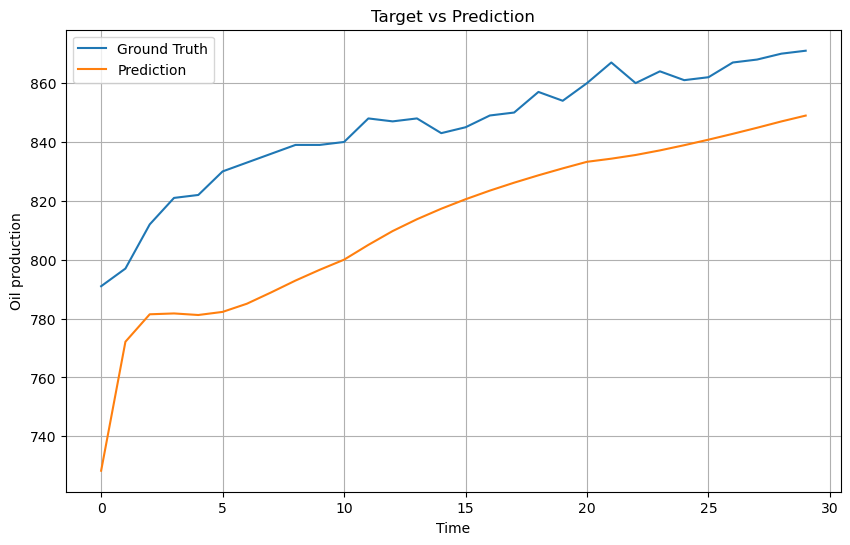

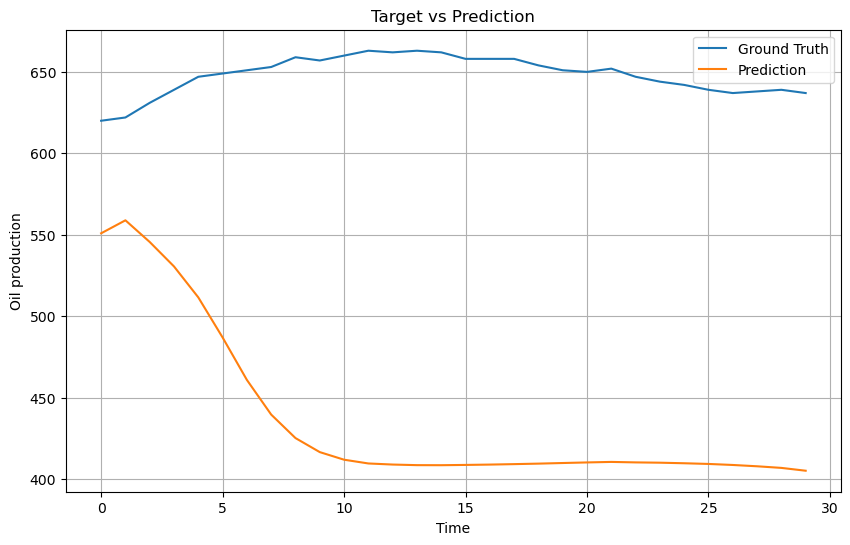

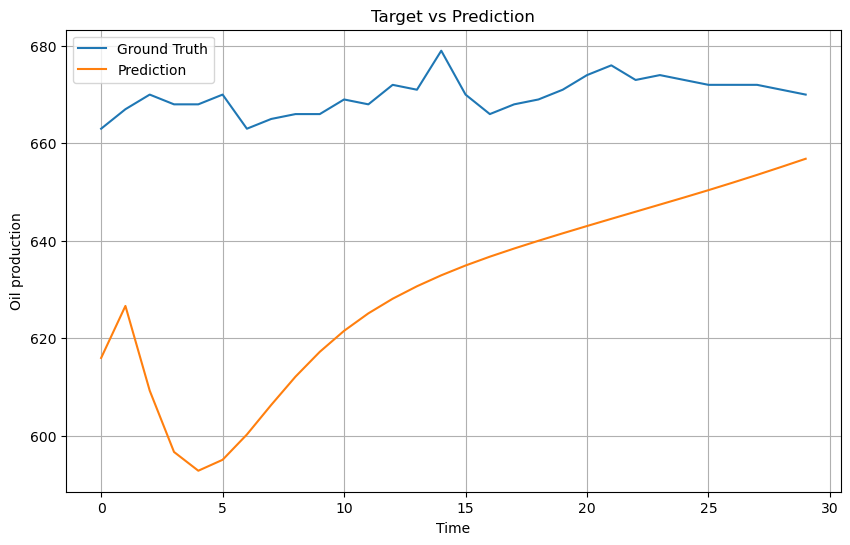

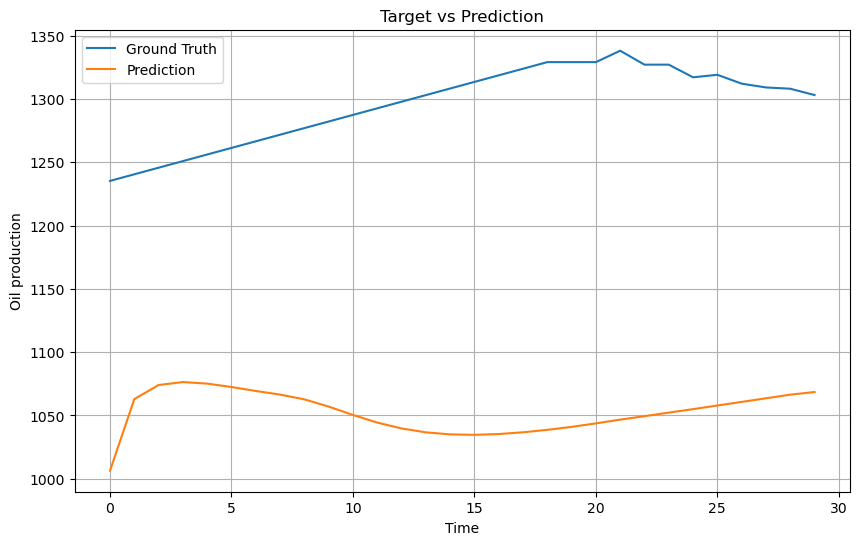

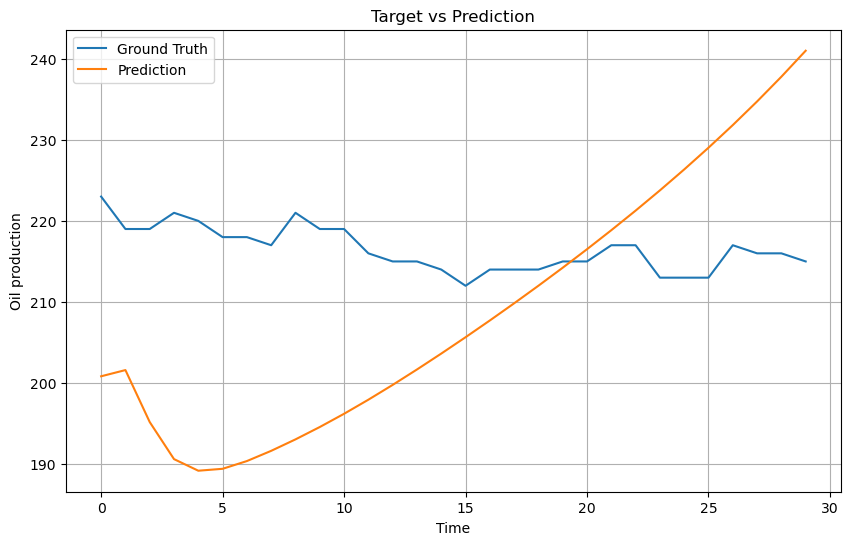

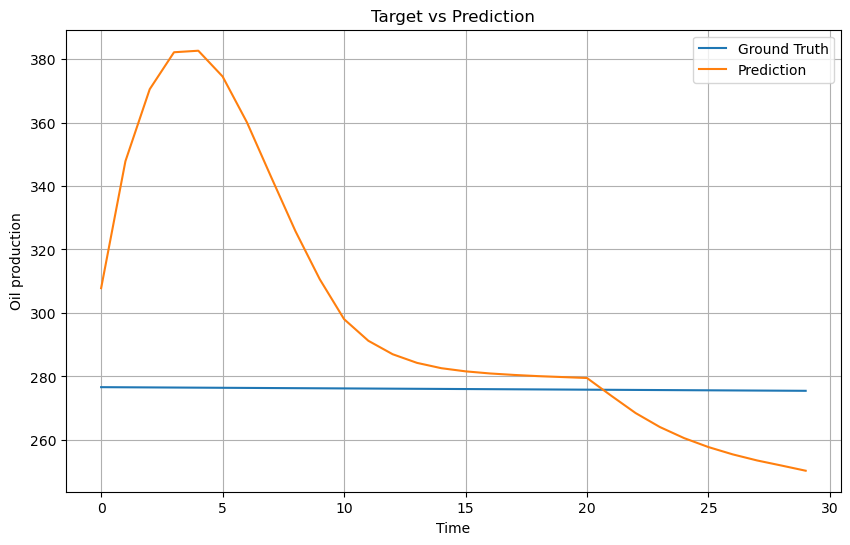

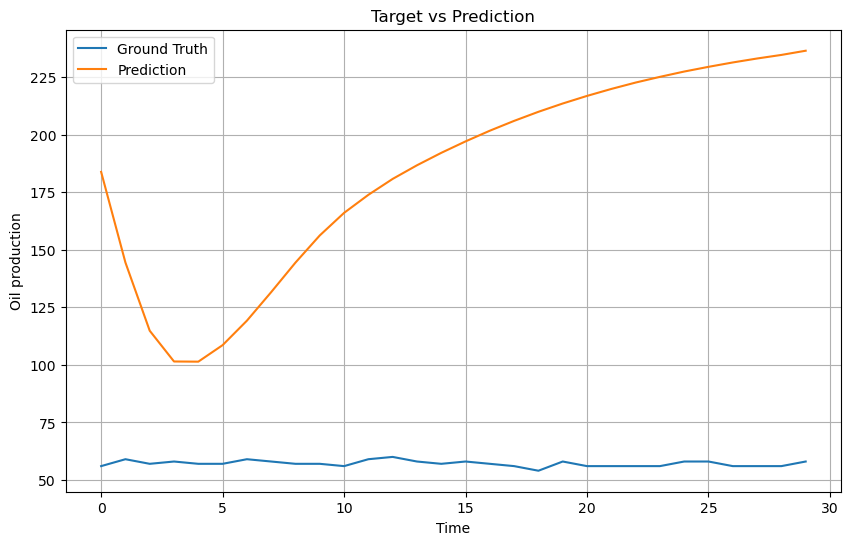

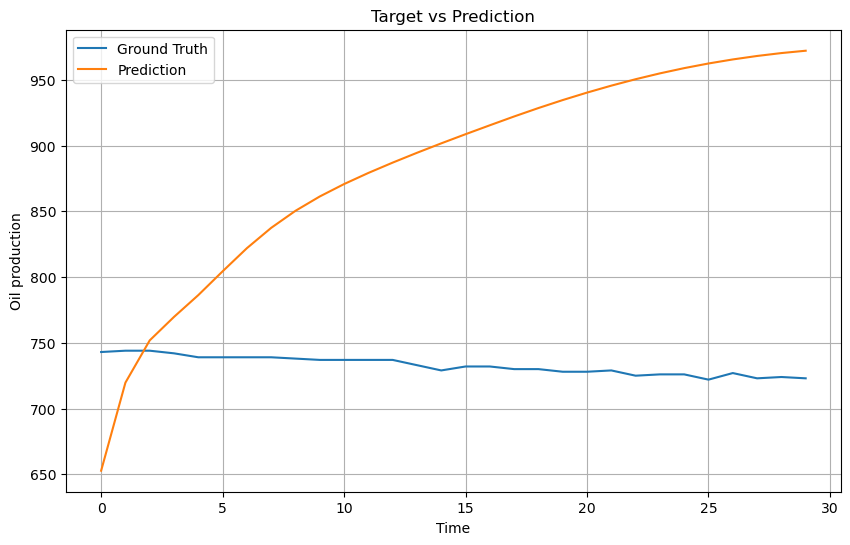

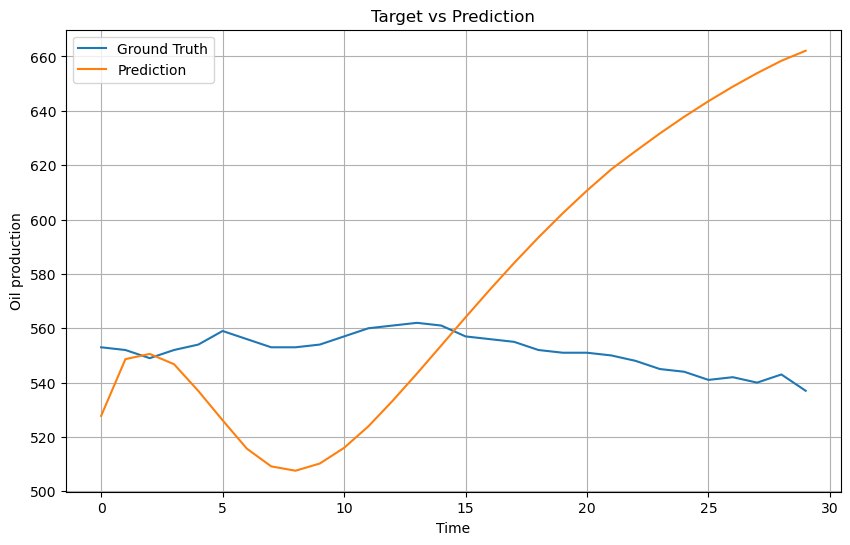

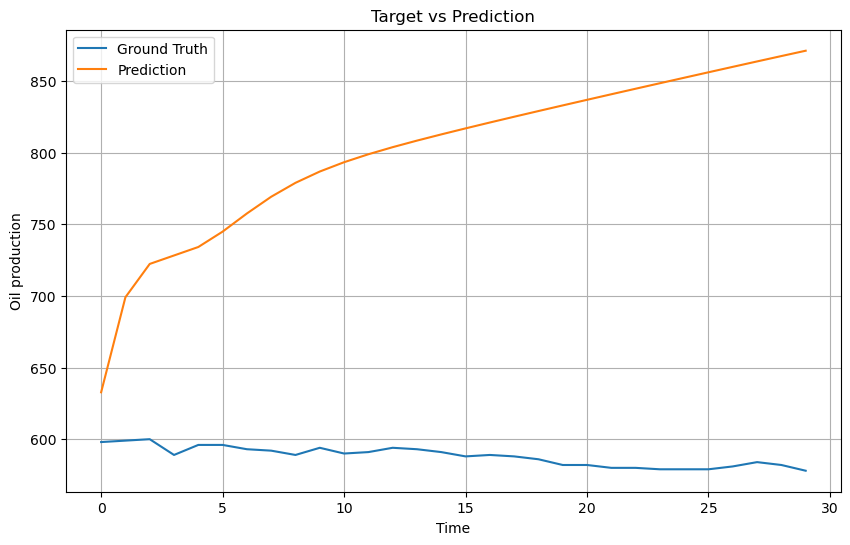

In [82]:
for i in range(y_t.shape[0]):
    plt.figure(figsize=(10, 6))
    plt.plot(y_t[i], label='Ground Truth')
    plt.plot(y_m[i], label='Prediction')
    plt.title('Target vs Prediction')
    plt.xlabel('Time')
    plt.ylabel('Oil production')
    plt.legend()
    plt.grid(True)
    plt.show()
    if i >= 9:
        break

In [97]:
# y_t[1, :]

In [96]:
# y_m[1, :]

In [79]:
test_data = list(zip(test_sequences_new, test_targets_new, test_target_sequences))

test_mape = 0
with torch.no_grad():
    model_seq2seq_gat.eval()
    for i, (sequence, target, target_seq) in enumerate(test_data):
    
        sequence, target = [T.ToUndirected()(snapshot).to(device) for snapshot in sequence], target.to(device)
        target_seq = [snapshot.to(device) for snapshot in target_seq]
            
        x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
        edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
        x_dict_sequence_target = [snapshot.x_dict for snapshot in target_seq]
            
        output = model_loaded(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 30, teacher_forcing=False)
    
        y_t = scaler_target.inverse_transform(target)
        y_m = scaler_target.inverse_transform(output)
        y_t, y_m = torch.tensor(y_t), torch.tensor(y_m)
        
        absolute_percentage_errors = torch.abs((y_t + 1e-8 - y_m) / (y_t + 1e-8))
        mape = torch.mean(absolute_percentage_errors) * 100
        test_mape += mape.item()

average_test_mape = test_mape / len(test_data)

In [81]:
print(f"Avg. MAPE on test data: {average_test_mape}%")

Avg. MAPE on test data: 96.47307714881109%


## Правильное отображение предсказаний

In [114]:
# for i in range(scaled_data.shape[1]):
#     scaled_data[:, i] = scaler_col1.inverse_transform(scaled_data[:, i].reshape(-1, 1)).reshape(1, -1)

# print("Обратное преобразование данных:")
# print(inverse_data)
# print(scaled_data)


In [ ]:
from sklearn.metrics import mean_squared_error

# Предположим, у нас есть модель и тестовый DataLoader
model = ...  # Ваша модель
test_loader = DataLoader(...)  # Тестовый DataLoader

# Переводим модель в режим оценки
model.eval()

# Для хранения предсказаний и истинных значений
all_predictions = []
all_targets = []

# Отключаем вычисление градиентов
with torch.no_grad():
    for inputs, targets in test_loader:
        # Перемещаем данные на устройство (например, GPU)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Получаем предсказания модели
        outputs = model(inputs)

        # Сохраняем предсказания и истинные значения
        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Вычисляем метрику (например, MSE)
mse = mean_squared_error(all_targets, all_predictions)
print(f"Test MSE: {mse}")

# Последовательность рабочих часов / размера дросселя

In [ ]:
import numpy as np

# Параметры
mean_working_hours = 20  # Среднее время работы
std_dev = 3  # Стандартное отклонение
probability_of_zero = 0.05  # Вероятность 0 часов работы

# Генерация последовательности
def generate_sequence(n_days):
    sequence = []
    for _ in range(n_days):
        if np.random.rand() < probability_of_zero:
            sequence.append(0)
        else:
            # Генерация времени работы с нормальным распределением
            working_hours = np.random.normal(mean_working_hours, std_dev)
            # Ограничение значений от 0 до 24
            working_hours = max(0, min(24, working_hours))
            sequence.append(round(working_hours))
    return sequence

# Пример генерации последовательности для 30 дней
sequence = generate_sequence(30)
print(sequence)

[21, 19, 20, 18, 18, 19, 21, 22, 18, 24, 19, 24, 22, 0, 22, 12, 21, 19, 24, 0, 15, 22, 24, 22, 20, 24, 24, 18, 24, 24]


# NetworkX

In [ ]:
!pip install networkx

In [ ]:
edges

[(1, 2, 1232.1043785735674),
 (2, 1, 1232.1043785735674),
 (1, 3, 707.4531030390735),
 (3, 1, 707.4531030390735),
 (1, 4, 331.63537205713743),
 (4, 1, 331.63537205713743),
 (2, 3, 967.7138858670936),
 (3, 2, 967.7138858670936),
 (2, 4, 1411.9199745380417),
 (4, 2, 1411.9199745380417),
 (3, 4, 641.6089932350584),
 (4, 3, 641.6089932350584)]

In [ ]:
import networkx as nx

G = nx.DiGraph()

# df_specific_month = df_specific_month.sort_values('group', ascending=False)

for _, well in production_wells.iterrows():
    G.add_node(well['cat'], type='P')

for _, well in injection_wells.iterrows():
    if well['cat'] in G.nodes:
        G.add_node(well['cat'] + 5, type='I')
    G.add_node(well['cat'] + 5, type='I')

G.add_weighted_edges_from(edges)

In [ ]:
G.nodes(data=True)

NodeDataView({3: {'type': 'P'}, 1: {'type': 'P'}, 2: {'type': 'P'}, 4: {'type': 'P'}, 5: {'type': 'I'}})

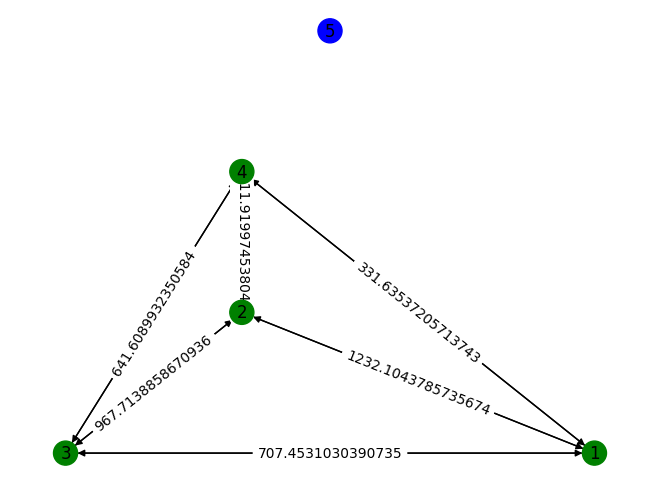

In [ ]:
import matplotlib.pyplot as plt
pos = nx.planar_layout(G)
node_colors = ['blue' if G.nodes[n]['type'] == 'I' else 'green' for n in G.nodes]
nx.draw(G, pos, with_labels=True, node_color=node_colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

# Создаение объектов PyTorch Geometric

In [105]:
import torch
from torch_geometric.data import Data

# Пример табличных данных: строки - записи, столбцы - признаки.
# Здесь используется простой пример данных.
table_data = [
    [1, 0, 3],  # Пример строки таблицы
    [2, 1, 0],
    [1, 2, 3],
    [0, 1, 1],
]

# Преобразуем табличные данные в тензор.
# Каждая строка - это отдельный узел графа.
node_features = torch.tensor(table_data, dtype=torch.float)

# Создаём список рёбер по какому-либо правилу.
# В этом примере рёбра создаются между каждым узлом и всеми остальными (полносвязный граф).
num_nodes = len(table_data)

edge_index = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:  # Условие для создания рёбер (например, исключаем петли, i != j)
            edge_index.append([i, j])

# edge_index должен быть 2D тензором размера [2, num_edges], где каждая колонка -- один край.
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Теперь создаём объект Data из PyTorch Geometric
data = Data(x=node_features, edge_index=edge_index)

print(data)

Data(x=[4, 3], edge_index=[2, 12])


In [ ]:
import pandas as pd

# Таблица пользователей
users_table = pd.DataFrame([
    {"user_id": 0, "preferred_category": 0, "min_price": 5.0, "max_price": 15.0},
    {"user_id": 1, "preferred_category": 1, "min_price": 10.0, "max_price": 30.0},
    {"user_id": 2, "preferred_category": 0, "min_price": 8.0, "max_price": 20.0},
])

# Таблица продуктов
products_table = pd.DataFrame([
    {"product_id": 0, "price": 10.0, "category": 0},
    {"product_id": 1, "price": 20.0, "category": 1},
    {"product_id": 2, "price": 12.0, "category": 0},
])

# Создаём таблицу взаимодействий
interaction_table = []

# Логика для определения взаимодействий
for _, user in users_table.iterrows():
    for _, product in products_table.iterrows():
        # Условие для взаимодействия:
        # - Категория продукта совпадает с предпочтением пользователя
        # - Цена продукта находится в диапазоне, доступном для пользователя
        if (product["category"] == user["preferred_category"] and
                product["price"] >= user["min_price"] and
                product["price"] <= user["max_price"]):
            interaction_table.append({
                "user_id": user["user_id"],
                "product_id": product["product_id"],
                "quantity": 1,  # Дополнительно: например, по умолчанию 1 штука
            })

# Преобразуем в DataFrame
interaction_table = pd.DataFrame(interaction_table)

# Вывод
print("Таблица пользователей:")
print(users_table)
print("\nТаблица продуктов:")
print(products_table)
print("\nТаблица взаимодействий:")
print(interaction_table.astype(int))

Таблица пользователей:
   user_id  preferred_category  min_price  max_price
0        0                   0        5.0       15.0
1        1                   1       10.0       30.0
2        2                   0        8.0       20.0

Таблица продуктов:
   product_id  price  category
0           0   10.0         0
1           1   20.0         1
2           2   12.0         0

Таблица взаимодействий:
   user_id  product_id  quantity
0        0           0         1
1        0           2         1
2        1           1         1
3        2           0         1
4        2           2         1


In [ ]:
import torch
from torch_geometric.data import HeteroData

# Пример табличных данных: два типа узлов с различными признаками.
table_data_users = [
    [0.5, 1.0],  # Пример признаков пользователя (2 features)
    [1.0, 0.8],
    [0.3, 0.5],
]

table_data_products = [
    [5.0, 3.0, 1.0],  # Пример признаков продукта (3 features)
    [2.0, 5.0, 2.0],
]

# Пример связей между узлами (типа "users" и "products").
user_to_product_edges = [
    [0, 0],  # Пользователь 0 связан с продуктом 0
    [1, 1],  # Пользователь 1 связан с продуктом 1
    [2, 0],  # Пользователь 2 связан с продуктом 0
    [2, 1],  # Пользователь 2 связан с продуктом 1
]

# Преобразуем данные в тензоры
user_features = torch.tensor(table_data_users, dtype=torch.float)
product_features = torch.tensor(table_data_products, dtype=torch.float)

# Индексы рёбер
edge_index_user_to_product = torch.tensor(user_to_product_edges, dtype=torch.long).t().contiguous()

# Создаём гетерогенный граф
data = HeteroData()

# Добавляем типы узлов и их признаки
data['user'].x = user_features  # Узлы типа "user"
data['product'].x = product_features  # Узлы типа "product"

# Добавляем типы рёбер и их связи
data['user', 'buys', 'product'].edge_index = edge_index_user_to_product

# Можно также добавлять признаки рёбер, если они есть:
# (Дополнительно) Пример весов рёбер (например, количество покупок)
edge_weights = [1.5, 2.0, 0.8, 1.0]
data['user', 'buys', 'product'].edge_attr = torch.tensor(edge_weights, dtype=torch.float)

# Проверяем итоговый гетерогенный граф
print(data)

In [ ]:
import torch
from torch_geometric.data import HeteroData

# Пример таблиц с данными
# Пользователи (nodes of type 'user')
users_table = [
    {"user_id": 0, "age": 25, "location": 0},
    {"user_id": 1, "age": 34, "location": 1},
    {"user_id": 2, "age": 23, "location": 0},
]

# Продукты (nodes of type 'product')
products_table = [
    {"product_id": 0, "price": 10.0, "category": 0},
    {"product_id": 1, "price": 20.0, "category": 1},
]

# Взаимодействия (edges of type 'buys')
interaction_table = [
    {"user_id": 0, "product_id": 0, "quantity": 1, "timestamp": 1620000000},
    {"user_id": 1, "product_id": 1, "quantity": 2, "timestamp": 1620003600},
    {"user_id": 2, "product_id": 0, "quantity": 1, "timestamp": 1620007200},
]

# Создаём гетерогенный граф
data = HeteroData()

# 1. Создаём узлы на основе табличных данных
# Узлы типа 'user'
user_features = torch.tensor([[u["age"], u["location"]] for u in users_table], dtype=torch.float)
data["user"].x = user_features  # Признаки узлов 'user'

# Узлы типа 'product'
product_features = torch.tensor([[p["price"], p["category"]] for p in products_table], dtype=torch.float)
data["product"].x = product_features  # Признаки узлов 'product'

# 2. Создаём рёбра на основе таблицы взаимодействий
# Составляем `edge_index` на основе `interaction_table`: указываем, кто с кем взаимодействует
edge_index_user_to_product = torch.tensor(
    [[interaction["user_id"], interaction["product_id"]] for interaction in interaction_table],
    dtype=torch.long,
).t().contiguous()  # Формат [2, num_edges] для edge_index

data["user", "buys", "product"].edge_index = edge_index_user_to_product  # Рёбра от user -> product

# (Дополнительно) Добавляем признаки для рёбер (например, количество покупок или время)
edge_quantity = torch.tensor([interaction["quantity"] for interaction in interaction_table], dtype=torch.float)
data["user", "buys", "product"].edge_attr = edge_quantity  # Признаки рёбер (количество покупок)

# 3. Проверяем итоговый гетерогенный граф
print(data)

In [37]:
train = [0.3521662672291614, 
0.3245682939492052, 
0.29901878308132046, 
0.2715495886482333, 
0.24470692860904397, 
0.21909893240169867, 
0.19603199027651505, 
0.17583935015826846, 
0.15844361974954643, 
0.14388096365630823, 
0.13117466125615074, 
0.11910438448723931, 
0.10720613086812143, 
0.09567954642000757, 
0.08446503294763916, 
0.07426485096488945, 
0.06533639014354796, 
0.057436433596680936, 
0.05066224681201154, 
0.045155179405102296, 
0.04055927528038799, 
0.036628108972781064, 
0.03320594822538608, 
0.03019101759483649, 
0.027516894015798935, 
0.025138978746388232, 
0.023017833163193998, 
0.021111282314475677, 
0.01938098317507168, 
0.017802563819489914, 
0.016355580969968524, 
0.015033251736306933, 
0.013822090689671789, 
0.01272262315154125, 
0.01172724905216448, 
0.010827597636390648, 
0.010014968656368846, 
0.00928427087299827, 
0.00862482480290966, 
0.008031985205247926,]

test = [
    0.5400883974063964,
0.5234245086315448,
0.5035641746861594,
0.48124657539778914,
0.45645706686708665,
0.43132678360219984,
0.4064481781904029,
0.3820805730958464,
0.357718220778874,
0.3337955579713539,
0.30982467137947284,
0.28531108094901636,
0.25915032254640386,
0.2305928268445232,
0.2021749328289713,
0.17396041143823554,
0.14862847140935995,
0.12650075643545106,
0.1068492664034089,
0.09100530464103614,
0.07988612203016168,
0.07046422804828989,
0.06324184876152132,
0.05729397093611104,
0.052146051591508605,
0.047877831103664545,
0.0437772808714755,
0.04040959716414806,
0.03703082983120882,
0.03417639146563868,
0.03159577047166528,
0.028981347179050168,
0.02669590457327782,
0.024560095710315245,
0.022503150257444572,
0.02068593042838589,
0.019138963195795892,
0.017609416416023302,
0.016332595771740354,
0.015187275339726103,
]

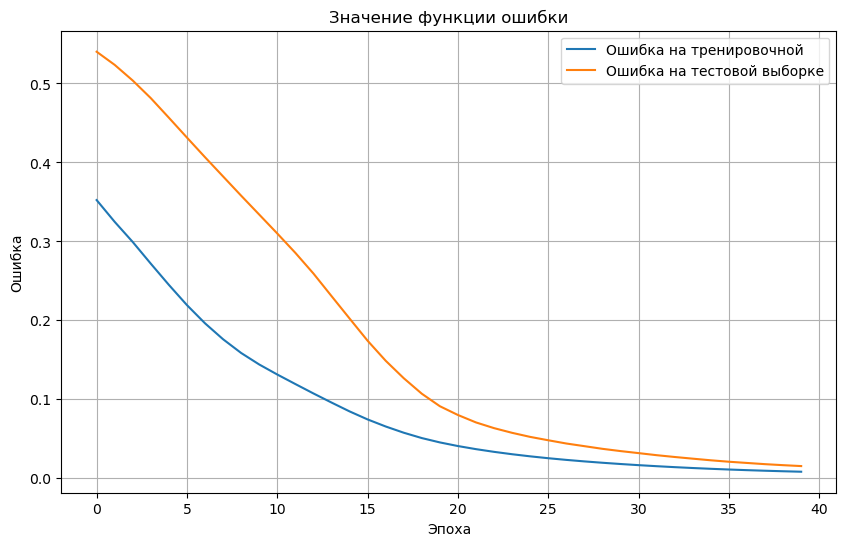

In [39]:
plot_loss(train, test)